# Analisi del consenso sui Bitcoin

Su richiesta di un'azienda di ricerche di mercato, si è svolta un'analisi del consenso sui Bitcoin a partire da un dataset di tweet sull'argomento. I risultati dell'analisi sono riportati in questo notebook, che ne segue le varie fasi dalla preparazione dei dati fino ai principali risultati.

Nella prima sezione saranno mostrate l'importazione dei dati forniti dall'azienda e la loro preparazione per l'analisi. Dopo una sezione dedicata a una panoramica sul dataset ottenuto, è stato analizzato il sentiment dal punto di vista temporale e dal punto di vista delle reazioni ai tweet.

In [1]:
!apt-get update
!apt-get install openjdk-11-jdk -y

!pip install pyspark pandas yfinance vaderSentiment nltk statsmodels matplotlib seaborn


Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 https://cli.github.com/packages stable InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [3,526 kB]
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Packages [9,437 kB]


In [2]:

!pip install pyspark pandas yfinance vaderSentiment nltk statsmodels matplotlib seaborn


# Caricamento del dataset dei tweet

## Caricamento e preprocessing dei tweets

In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["PATH"] += ":/usr/lib/jvm/java-11-openjdk-amd64/bin"


### ⚙️ Step 1 — Inizializzazione della SparkSession

Creazione della SparkSession
Si inizializza una sessione Spark, specificando:

- master("local[*]") per l’esecuzione locale su tutti i core disponibili;


- appName("BTC_Sentiment") per identificare l’applicazione.

In [4]:
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .master("local[*]")
    .appName("BTC_Sentiment")
    .getOrCreate()
)

spark


### 🧩 Step 2 — Caricamento dataset da link

Definizione del percorso del dataset
Si imposta l’URL remoto (bitcoin_tweets.csv) e il percorso locale temporaneo.

Download del file CSV
Il file viene scaricato tramite requests e salvato in /tmp.

Lettura del dataset con PySpark
Il CSV viene letto in un DataFrame con intestazioni e delimitatore esplicito.

Ispezione iniziale
Si visualizza lo schema e un’anteprima delle prime 5 righe.

In [5]:
# 🧩 Step 2 — Caricamento dataset da link
dataset_url = "https://proai-datasets.s3.eu-west-3.amazonaws.com/bitcoin_tweets.csv"
local_file_path = "/tmp/bitcoin_tweets.csv"

# Download file
import requests
response = requests.get(dataset_url)
with open(local_file_path, "wb") as f:
    f.write(response.content)

# Legge dataset in PySpark con delimitatore esplicito
df = spark.read.option("header", True).option("delimiter", ",").csv(local_file_path)

# Mostra schema e anteprima
df.printSchema()
df.show(5, truncate=False)


root
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- url: string (nullable = true)
 |-- timestamp: string (nullable = true)
 |-- replies: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- retweets: string (nullable = true)
 |-- text: string (nullable = true)

+----------------------+-------------+-------------------+----+----------------------+-------+-----+--------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id                    |user         |fullname           |url |timestamp             |replies|likes|retweets|text                                                                                                                                                                                                          

### 🧹 Step 3 — Pulizia completa dei tweet
🔹 Rimozione delle colonne inutili

Si eliminano user, fullname e url.

🔹 Filtraggio righe nulle e duplicati

Rimozione di righe con timestamp o text nulli e duplicati basati su tali colonne.

🔹 Conversione del timestamp

La colonna timestamp viene convertita in formato TimestampType.

🔹 Pulizia del testo dei tweet

Conversione in minuscolo

Rimozione di URL, menzioni, hashtag e caratteri non alfabetici

Normalizzazione degli spazi e scarto dei testi troppo brevi

Creazione della colonna cleaned_text tramite UDF

🔹 Filtraggio dei tweet non validi

Si mantengono solo righe con cleaned_text non nullo.

🔹 Tokenizzazione del testo

Si usa Tokenizer per generare la colonna tokens.

🔹 Rimozione delle stopwords

Con NLTK + StopWordsRemover si genera filtered_tokens.

🔹 Lemmatizzazione dei token

Si usa WordNetLemmatizer per creare la colonna lemmatized_text.

🔹 Filtraggio della lingua (inglese)

Si utilizza langdetect e si mantengono solo i tweet in inglese (lang == "en").

🔹 Selezione e salvataggio finale

Si esporta il DataFrame pulito in /tmp/bitcoin_tweets_cleaned.csv.

🔹 Anteprima dei risultati

Visualizzazione delle prime righe del dataset finale.



In [6]:
# 🧹 STEP 3 — Pulizia completa dei tweet

import re
from pyspark.sql.functions import col, to_timestamp, udf, size
from pyspark.sql.types import StringType, ArrayType
from pyspark.ml.feature import Tokenizer, StopWordsRemover

# 1️⃣ Rimozione colonne inutili
df_clean = df.drop("user", "fullname", "url")

# 2️⃣ Filtraggio righe nulle e duplicati
df_clean = (
    df_clean
    .filter(col("timestamp").isNotNull())
    .filter(col("text").isNotNull())
    .dropDuplicates(["timestamp", "text"])
)

# 3️⃣ Conversione timestamp
df_clean = df_clean.withColumn("timestamp", to_timestamp(col("timestamp")))

# 4️⃣ Pulizia del testo
def clean_tweet(text):
    if text is None:
        return None
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # URL
    text = re.sub(r"@\w+", "", text)                    # menzioni
    text = re.sub(r"#\w+", "", text)                    # hashtag
    text = re.sub(r"[^a-z\s]", " ", text)               # non alfabetici
    text = re.sub(r"\s+", " ", text).strip()            # spazi doppi
    return text if len(text) >= 5 else None             # scarta testi troppo corti

clean_udf = udf(clean_tweet, StringType())
df_clean = df_clean.withColumn("cleaned_text", clean_udf(col("text")))

# 5️⃣ Filtra tweet non validi o troppo corti
df_clean = df_clean.filter(col("cleaned_text").isNotNull())

# 6️⃣ Tokenizzazione
tokenizer = Tokenizer(inputCol="cleaned_text", outputCol="tokens")
df_clean = tokenizer.transform(df_clean)

# 7️⃣ Rimozione stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens", stopWords=stop_words)
df_clean = remover.transform(df_clean)

# 8️⃣ Lemmatizzazione
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    if not tokens:
        return []
    return [lemmatizer.lemmatize(t) for t in tokens]

lemm_udf = udf(lemmatize_tokens, ArrayType(StringType()))
df_clean = df_clean.withColumn("lemmatized_text", lemm_udf(col("filtered_tokens")))

# 9️⃣ Filtra solo tweet inglesi (semplificato: mantiene se > metà token in inglese)
# libreria language detection
!pip install langdetect > /dev/null
from langdetect import detect

def detect_lang(text):
    try:
        return detect(text)
    except:
        return None

lang_udf = udf(detect_lang, StringType())
df_clean = df_clean.withColumn("lang", lang_udf(col("cleaned_text")))
df_clean = df_clean.filter(col("lang") == "en")

# 🔟 Selezione colonne finali
df_final = df_clean.select("id", "timestamp", "replies", "likes", "retweets", "lemmatized_text")

from pyspark.sql.functions import concat_ws, col

# Converti lemmatized_text da array a stringa
df_final_csv = df_final.withColumn("lemmatized_text", concat_ws(" ", col("lemmatized_text")))

# Esporta CSV
output_path = "/tmp/bitcoin_tweets_cleaned.csv"
df_final_csv.write.mode("overwrite").option("header", True).csv(output_path)


# ✅ Anteprima finale
df_final.show(5, truncate=False)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


+------------------------------------+-------------------+--------------------------------------------------------------+-----------------------+----------+--------------------------------------------------------+
|id                                  |timestamp          |replies                                                       |likes                  |retweets  |lemmatized_text                                         |
+------------------------------------+-------------------+--------------------------------------------------------------+-----------------------+----------+--------------------------------------------------------+
|Buy $BTC Bitcoin. As many as you can|NULL               | until the end of December 2017. Then sell 1/2 of it. The rest| sell whenever you want| give away|[help, people]                                          |
|1110302988.0                        |2009-01-11 03:33:52|790.0                                                         |14470.0                

1. **Definizione della funzione per calcolare il sentimento**:
   - La funzione `analyze_sentiment` prende in input un testo.
   - Viene usato Vader perfetto per i social.
   - Si determina la polarità del testo e si ritorna il corrispondente sentimento:
     - `positive` se la polarità è maggiore di 0.
     - `negative` se la polarità è minore di 0.
     - `neutral` se la polarità è uguale a 0.

2. **Registrazione della funzione definita dall'utente (UDF)**:
   - La funzione `analyze_sentiment` viene registrata come una UDF (User-Defined Function) per poter essere utilizzata con i DataFrame di Spark.

3. **Applicazione della UDF al DataFrame**:
   - Si applica la UDF al DataFrame per creare una nuova colonna "sentiment" contenente il risultato dell'analisi del sentimento per ogni riga.

4. **Filtro le righe nulle**:
   - Si fltrano le righe che hanno `lemmatized_text` nullo.

5. **Creazione di una colonna di data combinata**:
   - Viene creata una nuova colonna `date` nel formato `"yyyy-MM-dd"` a partire dalla colonna `"timestamp"`.   

6. **Visualizzazione del DataFrame aggiornato**:
   - Si mostra il DataFrame aggiornato con la nuova colonna "sentiment".

In [7]:
# 🧪 STEP 4 — Analisi del Sentiment con VADER

from pyspark.sql.functions import udf, to_date, col
from pyspark.sql.types import StringType
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# 1️⃣ Inizializza VADER
analyzer = SentimentIntensityAnalyzer()

# 2️⃣ Definizione funzione per classificare sentiment
def analyze_sentiment(text):
    if text is None or len(text) == 0:
        return "neutral"
    # Se è un array di token, unisci in stringa
    if isinstance(text, list):
        text = " ".join(text)
    score = analyzer.polarity_scores(text)["compound"]
    if score >= 0.05:
        return "positive"
    elif score <= -0.05:
        return "negative"
    else:
        return "neutral"

# 3️⃣ Registrazione UDF
sent_udf = udf(analyze_sentiment, StringType())

# 4️⃣ Applicazione al DataFrame
df_sentiment = df_final.withColumn("sentiment", sent_udf(col("lemmatized_text")))

# 5️⃣ Filtro righe nulle (già pulito, ma sicurezza)
df_sentiment = df_sentiment.filter(col("lemmatized_text").isNotNull())

# 6️⃣ Creazione colonna data
df_sentiment = df_sentiment.withColumn("date", to_date(col("timestamp")))

# 7️⃣ Anteprima risultati
df_sentiment.select("id", "lemmatized_text", "sentiment", "date").show(5, truncate=False)


+------------------------------------+--------------------------------------------------------+---------+----------+
|id                                  |lemmatized_text                                         |sentiment|date      |
+------------------------------------+--------------------------------------------------------+---------+----------+
|Buy $BTC Bitcoin. As many as you can|[help, people]                                          |positive |NULL      |
|1110302988.0                        |[running, bitcoin]                                      |neutral  |2009-01-11|
|3.6846493069069926e+17              |[leah, went, btc, spent, data, card, much, leave, store]|negative |2013-08-16|
|4.098666163865068e+17               |[price, bitcoin, usd, time, buy]                        |neutral  |2013-12-09|
|4.135790801690337e+17               |[price, bitcoin, usd, lmfao, nooooooo]                  |positive |2013-12-19|
+------------------------------------+--------------------------

Per completare il DataFrame con tutte le informazioni necessarie all’analisi, abbiamo unito i dati del sentiment con le colonne numeriche originali dei tweet (likes, replies, retweets) presenti nel dataset iniziale.

La join è stata fatta sulla colonna id, che identifica univocamente ogni tweet.

Dopo l’unione, il DataFrame contiene sia il sentiment calcolato con VADER sia i dati di engagement per ciascun tweet.

Abbiamo inoltre convertito le colonne numeriche in formato float e filtrato eventuali righe senza data valida (date), in modo da preparare il dataset per i grafici e le analisi successive.

In questo modo il DataFrame finale è completo e pronto per visualizzare l’andamento del sentiment nel tempo e confrontarlo con likes, risposte e retweet.

In [8]:
# Rinominare le colonne per evitare ambiguità
df_final_alias = df_final.select(
    col("id").alias("id_join"),
    col("likes").alias("likes_orig"),
    col("replies").alias("replies_orig"),
    col("retweets").alias("retweets_orig")
)

# Join usando id
df_sentiment_full = df_sentiment.join(
    df_final_alias,
    df_sentiment.id == df_final_alias.id_join,
    how="left"
).drop("id_join")  # rimuove colonna duplicata

# Controllo output
df_sentiment_full.select(
    "id", "lemmatized_text", "sentiment", "date", "likes_orig", "replies_orig", "retweets_orig"
).show(5, truncate=False)


+------------------------------------+--------------------------------------------------------+---------+----------+-----------------------+--------------------------------------------------------------+-------------+
|id                                  |lemmatized_text                                         |sentiment|date      |likes_orig             |replies_orig                                                  |retweets_orig|
+------------------------------------+--------------------------------------------------------+---------+----------+-----------------------+--------------------------------------------------------------+-------------+
|Buy $BTC Bitcoin. As many as you can|[help, people]                                          |positive |NULL      | sell whenever you want| until the end of December 2017. Then sell 1/2 of it. The rest| give away   |
|1110302988.0                        |[running, bitcoin]                                      |neutral  |2009-01-11|14470.0     



1. Sommiamo i valori nelle colonne likes, replies e retweets, è stata ottenuta la colonna reactions che conta le reazioni totali al tweet.
2. **Raggruppamento per la nuova colonna di data combinata e sentimento**: - Il DataFrame è raggruppato per le colonne date e sentiment.
3. Viene calcolato il conteggio dei sentimenti per ogni combinazione di data e sentiment.
4. I risultati sono ordinati per date.
5. Il primo tweet ha date = NULL perché il timestamp originale era NULL. Possiamo decidere di scartare queste righe prima di aggregare, così non influiscono sul grafico giornaliero.



In [9]:
from pyspark.sql.functions import col, lit, coalesce, count, sum as _sum

# 1️⃣ Creazione colonna reactions
df_sentiment_full = df_sentiment_full.withColumn(
    "reactions",
    coalesce(col("likes_orig"), lit(0)) +
    coalesce(col("replies_orig"), lit(0)) +
    coalesce(col("retweets_orig"), lit(0))
)

# 2️⃣ Filtra righe senza data valida
df_sentiment_clean = df_sentiment_full.filter(col("date").isNotNull())

# 3️⃣ Raggruppamento per data e sentiment
daily_sentiment = (
    df_sentiment_clean.groupBy("date", "sentiment")
    .agg(
        count("id").alias("tweet_count"),
        _sum("reactions").alias("total_reactions")
    )
    .orderBy("date")
)

# 4️⃣ Visualizza anteprima
daily_sentiment.show(5, truncate=False)



+----------+---------+-----------+---------------+
|date      |sentiment|tweet_count|total_reactions|
+----------+---------+-----------+---------------+
|2009-01-11|neutral  |1          |20802.0        |
|2012-08-02|positive |1          |0.0            |
|2013-08-16|negative |1          |7.0            |
|2013-12-09|neutral  |1          |0.0            |
|2013-12-19|positive |1          |2.0            |
+----------+---------+-----------+---------------+
only showing top 5 rows



In [10]:
# 📅 Calcolo del sentiment medio mensile e rapporto positivo/negativo
from pyspark.sql import functions as F

# 1️⃣ Raggruppa per anno-mese
monthly_sentiment = (
    df_sentiment_clean
    .withColumn("year_month", F.date_format(F.col("date"), "yyyy-MM"))
    .groupBy("year_month")
    .agg(
        (F.sum(F.when(F.col("sentiment") == "positive", 1).otherwise(0)) / F.count("*")).alias("pos_ratio"),
        (F.sum(F.when(F.col("sentiment") == "negative", 1).otherwise(0)) / F.count("*")).alias("neg_ratio")
    )
    .orderBy("year_month")
)

# 2️⃣ Conversione a Pandas
monthly_pd = monthly_sentiment.toPandas()
monthly_pd.head()


,year_month,pos_ratio,neg_ratio
0,2009-01,0.000000,0.0
1,2012-08,1.000000,0.0
2,2013-08,0.000000,1.0
3,2013-12,0.333333,0.0
4,2014-02,1.000000,0.0


# ANALISI SENTIMENT

### 📆 Aggregazione mensile

In [11]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=monthly_pd["year_month"],
    y=monthly_pd["pos_ratio"],
    mode="lines+markers",
    name="Positivo",
    line=dict(color="#4CAF50")
))
fig.add_trace(go.Scatter(
    x=monthly_pd["year_month"],
    y=monthly_pd["neg_ratio"],
    mode="lines+markers",
    name="Negativo",
    line=dict(color="#F44336")
))

fig.update_layout(
    title="Andamento mensile del Sentiment (Positivo vs Negativo)",
    xaxis_title="Anno-Mese",
    yaxis_title="Rapporto di Sentiment",
    template="plotly_white"
)
fig.show()



###  📆 Aggregazione annuale e focus sul 2019

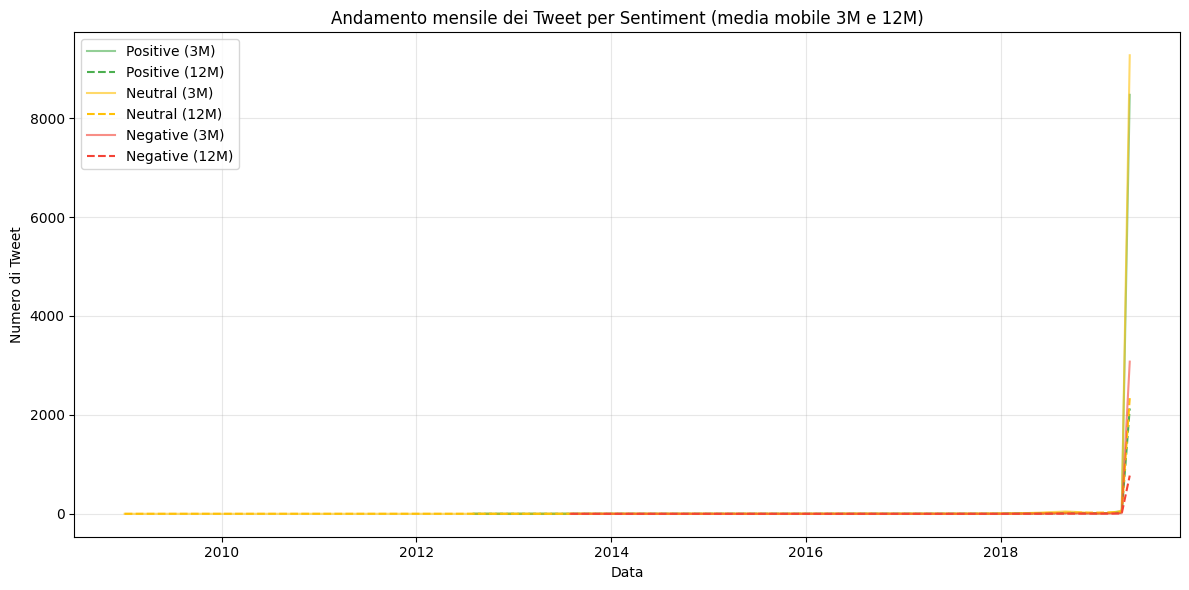

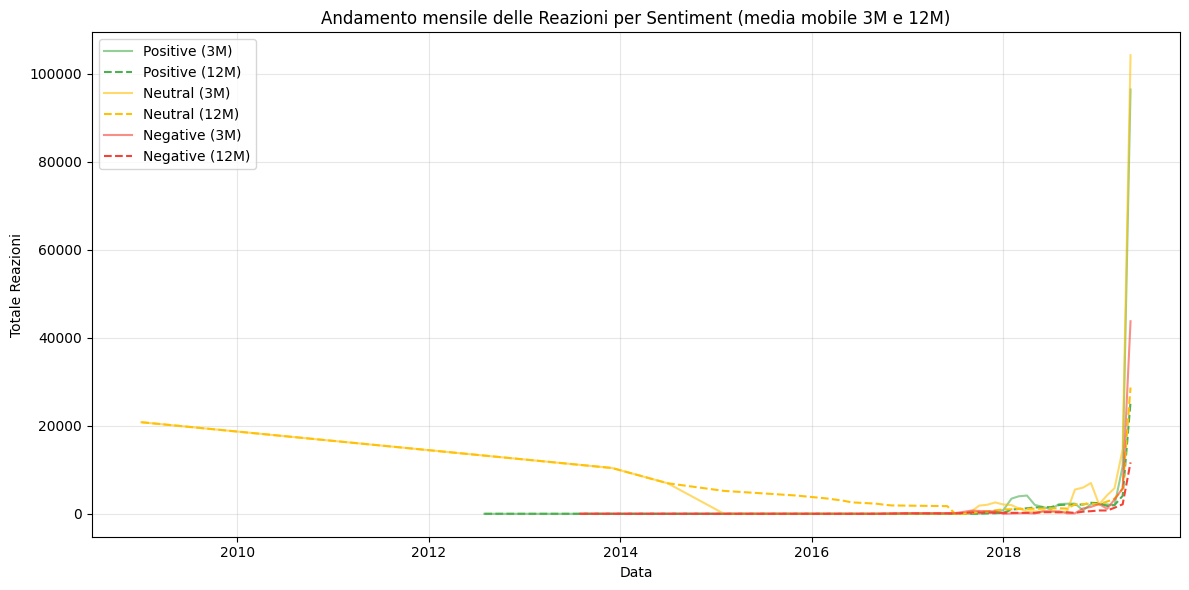

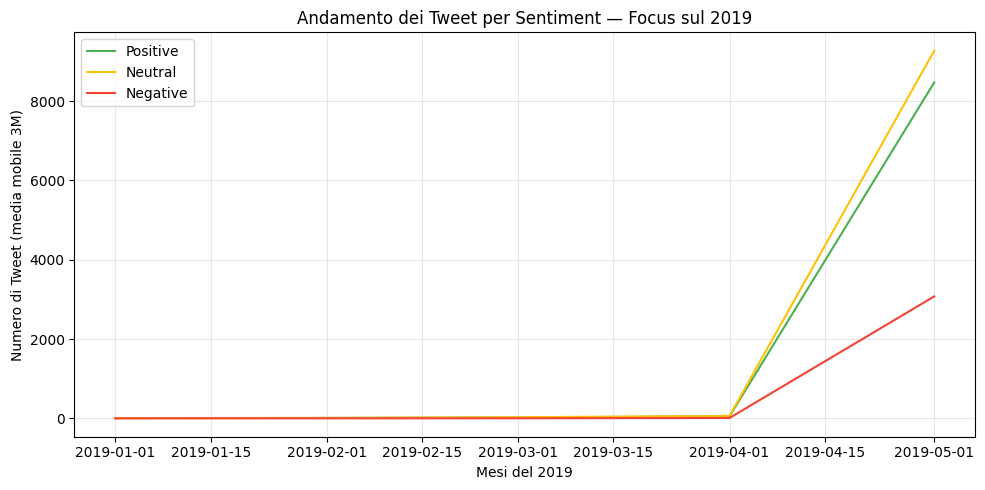

In [12]:
import pandas as pd
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# 🔹 Raggruppa per anno e mese
monthly_sentiment = (
    df_sentiment_clean
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .groupBy("year", "month", "sentiment")
    .agg(
        F.count("id").alias("tweet_count"),
        F.sum("reactions").alias("total_reactions")
    )
    .orderBy("year", "month")
)

# 🔄 Conversione a Pandas
monthly_pd = monthly_sentiment.toPandas()
monthly_pd["date"] = pd.to_datetime(monthly_pd["year"].astype(str) + "-" + monthly_pd["month"].astype(str) + "-01")

# 🔹 Medie mobili (3 e 12 mesi)
monthly_pd["tweet_count_3m"] = (
    monthly_pd.groupby("sentiment")["tweet_count"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)
monthly_pd["tweet_count_12m"] = (
    monthly_pd.groupby("sentiment")["tweet_count"]
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)
monthly_pd["reactions_3m"] = (
    monthly_pd.groupby("sentiment")["total_reactions"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)
monthly_pd["reactions_12m"] = (
    monthly_pd.groupby("sentiment")["total_reactions"]
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

# 🎨 Colori coerenti
colors = {"positive": "#4CAF50", "negative": "#F44336", "neutral": "#FFC107"}

# === 📊 GRAFICO 1 — Tweet mensili (trend breve e lungo periodo) ===
plt.figure(figsize=(12,6))
for sentiment in ["positive", "neutral", "negative"]:
    data = monthly_pd[monthly_pd["sentiment"] == sentiment]
    plt.plot(data["date"], data["tweet_count_3m"], color=colors[sentiment], alpha=0.6, label=f"{sentiment.capitalize()} (3M)")
    plt.plot(data["date"], data["tweet_count_12m"], color=colors[sentiment], linestyle="--", label=f"{sentiment.capitalize()} (12M)")
plt.title("Andamento mensile dei Tweet per Sentiment (media mobile 3M e 12M)")
plt.xlabel("Data")
plt.ylabel("Numero di Tweet")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === 📊 GRAFICO 2 — Reazioni mensili (trend breve e lungo periodo) ===
plt.figure(figsize=(12,6))
for sentiment in ["positive", "neutral", "negative"]:
    data = monthly_pd[monthly_pd["sentiment"] == sentiment]
    plt.plot(data["date"], data["reactions_3m"], color=colors[sentiment], alpha=0.6, label=f"{sentiment.capitalize()} (3M)")
    plt.plot(data["date"], data["reactions_12m"], color=colors[sentiment], linestyle="--", label=f"{sentiment.capitalize()} (12M)")
plt.title("Andamento mensile delle Reazioni per Sentiment (media mobile 3M e 12M)")
plt.xlabel("Data")
plt.ylabel("Totale Reazioni")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# === 🔍 FOCUS: SOLO ANNO 2019 ===
focus_2019 = monthly_pd[(monthly_pd["date"] >= "2019-01-01") & (monthly_pd["date"] <= "2019-12-31")]

plt.figure(figsize=(10,5))
for sentiment in ["positive", "neutral", "negative"]:
    data = focus_2019[focus_2019["sentiment"] == sentiment]
    plt.plot(data["date"], data["tweet_count_3m"], label=sentiment.capitalize(), color=colors[sentiment])
plt.title("Andamento dei Tweet per Sentiment — Focus sul 2019")
plt.xlabel("Mesi del 2019")
plt.ylabel("Numero di Tweet (media mobile 3M)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [13]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

# 🔹 Raggruppa per anno e mese
monthly_sentiment = (
    df_sentiment_clean
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .groupBy("year", "month", "sentiment")
    .agg(
        F.count("id").alias("tweet_count"),
        F.sum("reactions").alias("total_reactions")
    )
    .orderBy("year", "month")
)

# 🔄 Conversione a Pandas
monthly_pd = monthly_sentiment.toPandas()
monthly_pd["date"] = pd.to_datetime(
    monthly_pd["year"].astype(str) + "-" + monthly_pd["month"].astype(str) + "-01"
)

# 🔹 Calcolo medie mobili (3M e 12M)
monthly_pd["tweet_count_3m"] = (
    monthly_pd.groupby("sentiment")["tweet_count"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)
monthly_pd["tweet_count_12m"] = (
    monthly_pd.groupby("sentiment")["tweet_count"]
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)
monthly_pd["reactions_3m"] = (
    monthly_pd.groupby("sentiment")["total_reactions"]
    .transform(lambda x: x.rolling(window=3, min_periods=1).mean())
)
monthly_pd["reactions_12m"] = (
    monthly_pd.groupby("sentiment")["total_reactions"]
    .transform(lambda x: x.rolling(window=12, min_periods=1).mean())
)

colors = {"positive": "#4CAF50", "neutral": "#FFC107", "negative": "#F44336"}

# === 📊 GRAFICO 1 — Tweet mensili (3M e 12M) ===
fig1 = go.Figure()
for sentiment in ["positive", "neutral", "negative"]:
    df = monthly_pd[monthly_pd["sentiment"] == sentiment]
    fig1.add_trace(go.Scatter(
        x=df["date"], y=df["tweet_count_3m"],
        mode="lines", name=f"{sentiment.capitalize()} (3M)",
        line=dict(color=colors[sentiment], width=2)
    ))
    fig1.add_trace(go.Scatter(
        x=df["date"], y=df["tweet_count_12m"],
        mode="lines", name=f"{sentiment.capitalize()} (12M)",
        line=dict(color=colors[sentiment], dash="dash")
    ))

fig1.update_layout(
    title="📈 Andamento mensile dei Tweet per Sentiment (media mobile 3M e 12M)",
    xaxis_title="Data",
    yaxis_title="Numero di Tweet",
    template="plotly_white",
    legend=dict(x=0.02, y=0.98)
)
fig1.show()

# === 📊 GRAFICO 2 — Reazioni mensili (3M e 12M) ===
fig2 = go.Figure()
for sentiment in ["positive", "neutral", "negative"]:
    df = monthly_pd[monthly_pd["sentiment"] == sentiment]
    fig2.add_trace(go.Scatter(
        x=df["date"], y=df["reactions_3m"],
        mode="lines", name=f"{sentiment.capitalize()} (3M)",
        line=dict(color=colors[sentiment], width=2)
    ))
    fig2.add_trace(go.Scatter(
        x=df["date"], y=df["reactions_12m"],
        mode="lines", name=f"{sentiment.capitalize()} (12M)",
        line=dict(color=colors[sentiment], dash="dash")
    ))

fig2.update_layout(
    title="💬 Andamento mensile delle Reazioni per Sentiment (media mobile 3M e 12M)",
    xaxis_title="Data",
    yaxis_title="Totale Reazioni",
    template="plotly_white",
    legend=dict(x=0.02, y=0.98)
)
fig2.show()

# === 🔍 GRAFICO 3 — Focus 2019 ===
focus_2019 = monthly_pd[
    (monthly_pd["date"] >= "2019-01-01") & (monthly_pd["date"] <= "2019-12-31")
]

fig3 = go.Figure()
for sentiment in ["positive", "neutral", "negative"]:
    df = focus_2019[focus_2019["sentiment"] == sentiment]
    fig3.add_trace(go.Scatter(
        x=df["date"], y=df["tweet_count_3m"],
        mode="lines+markers",
        name=sentiment.capitalize(),
        line=dict(color=colors[sentiment], width=2)
    ))

fig3.update_layout(
    title="🔍 Andamento dei Tweet per Sentiment — Focus sul 2019",
    xaxis_title="Mesi del 2019",
    yaxis_title="Numero di Tweet (media mobile 3M)",
    template="plotly_white",
    legend=dict(x=0.02, y=0.98)
)
fig3.show()


In [14]:
from pyspark.sql import functions as F

# Conteggio totale per sentiment
sentiment_summary = (
    df_sentiment_clean
    .groupBy("sentiment")
    .agg(F.count("*").alias("tweet_count"))
    .orderBy(F.desc("tweet_count"))
)

# Calcola la percentuale
total_tweets = df_sentiment_clean.count()
sentiment_summary = sentiment_summary.withColumn(
    "percentage",
    (F.col("tweet_count") / total_tweets * 100).cast("double")
)

sentiment_summary.show()


+---------+-----------+------------------+
|sentiment|tweet_count|        percentage|
+---------+-----------+------------------+
|  neutral|      28199| 44.63562112194504|
| positive|      25671| 40.63410155755351|
| negative|       9296|14.714448524756238|
+---------+-----------+------------------+



In [15]:
from pyspark.sql.functions import count

# 🔹 Conta i tweet totali per sentiment
sentiment_counts = (
    df_sentiment_clean
    .groupBy("sentiment")
    .agg(count("*").alias("tweet_count"))
    .orderBy("tweet_count", ascending=False)
    .toPandas()
)

sentiment_counts


,sentiment,tweet_count
0,neutral,28219
1,positive,25640
2,negative,9302


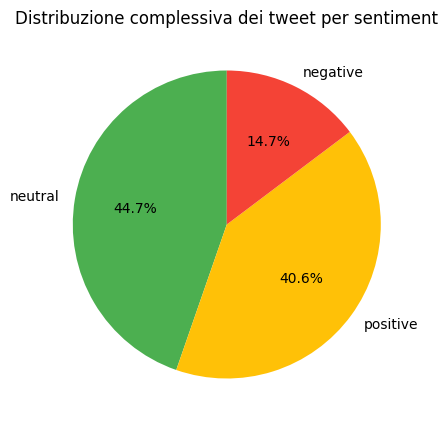

In [16]:
plt.figure(figsize=(5,5))
plt.pie(
    sentiment_counts["tweet_count"],
    labels=sentiment_counts["sentiment"],
    autopct="%1.1f%%",
    colors=["#4CAF50", "#FFC107", "#F44336"],
    startangle=90
)
plt.title("Distribuzione complessiva dei tweet per sentiment")
plt.show()


Riepilogo complessivo:
I tweet analizzati risultano distribuiti come segue:

~40.6% positivi

~44.7% neutri

~14.7% negativi

Questo bilanciamento indica una prevalenza di percezioni neutre verso il Bitcoin, con una quota di tweet negativi più contenuta ma potenzialmente più reattiva in corrispondenza di variazioni di prezzo.

## Il dataset *btc_usd*

In questa sottosezione si prepareranno i dati relativi allo storico dei prezzi dei Bitcoin, ottenuti tramite file CSV scaricato [da questo link](https://finance.yahoo.com/quote/BTC-USD/history/).
Nella tabella importata in questo notebook troviamo le seguenti colonne:
- La colonna *date* riporta la data dell'osservazione sui prezzi;
- La colonna *open_price* indica il prezzo all'apertura delle borse;
- La colonna *close_price* indica il prezzo alla chiusura delle borse.

Dalle ultime due colonne è stata calcolata la colonna *mean_price*, che indica il prezzo medio dei Bitcoin. Per semplicità, si è posto che il prezzo medio sia dato dalla media aritmetica dei prezzi di apertura e chiusura.

In [17]:
import yfinance as yf
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, round

# 🔹 Crea sessione Spark
spark = SparkSession.builder.getOrCreate()

# 🔹 Scarica dati storici BTC
btc = yf.download("BTC-USD", start="2014-11-17", progress=False)

# 🔹 Appiattisci le colonne multi-index (rimuove il ticker)
btc.columns = btc.columns.get_level_values(0)

# 🔹 Reset dell’indice per avere la colonna "Date"
btc.reset_index(inplace=True)

# 🔹 Rinomina le colonne
btc = btc.rename(columns={
    "Date": "date",
    "Open": "open_price",
    "High": "high_price",
    "Low": "low_price",
    "Close": "close_price",
    "Adj Close": "adj_close_price",
    "Volume": "volume_price"
})

# 🔹 Conversione a Spark
df_btc = spark.createDataFrame(btc)

# 🔹 Controllo anteprima
df_btc.show(5, truncate=False)
df_btc.printSchema()

/tmp/ipython-input-800300208.py:10: FutureWarning:

YF.download() has changed argument auto_adjust default to True



+-------------------+------------------+-----------------+------------------+-----------------+------------+
|date               |close_price       |high_price       |low_price         |open_price       |volume_price|
+-------------------+------------------+-----------------+------------------+-----------------+------------+
|2014-11-17 00:00:00|387.4079895019531 |410.1990051269531|377.50201416015625|388.3489990234375|41518800    |
|2014-11-18 00:00:00|375.197998046875  |392.4020080566406|371.11700439453125|387.7850036621094|32222500    |
|2014-11-19 00:00:00|380.55499267578125|386.4809875488281|373.89599609375   |373.89599609375  |18931800    |
|2014-11-20 00:00:00|357.8399963378906 |382.0249938964844|356.781005859375  |380.3070068359375|25233200    |
|2014-11-21 00:00:00|350.8479919433594 |357.8789978027344|344.11199951171875|357.8789978027344|29850100    |
+-------------------+------------------+-----------------+------------------+-----------------+------------+
only showing top 5 

In [18]:
# 🔹 Calcolo prezzo medio
df_btc = df_btc.withColumn(
    "mean_price",
    round((col("open_price") + col("close_price")) / 2, 2)
)

df_btc.show(5, truncate=False)

+-------------------+------------------+-----------------+------------------+-----------------+------------+----------+
|date               |close_price       |high_price       |low_price         |open_price       |volume_price|mean_price|
+-------------------+------------------+-----------------+------------------+-----------------+------------+----------+
|2014-11-17 00:00:00|387.4079895019531 |410.1990051269531|377.50201416015625|388.3489990234375|41518800    |387.88    |
|2014-11-18 00:00:00|375.197998046875  |392.4020080566406|371.11700439453125|387.7850036621094|32222500    |381.49    |
|2014-11-19 00:00:00|380.55499267578125|386.4809875488281|373.89599609375   |373.89599609375  |18931800    |377.23    |
|2014-11-20 00:00:00|357.8399963378906 |382.0249938964844|356.781005859375  |380.3070068359375|25233200    |369.07    |
|2014-11-21 00:00:00|350.8479919433594 |357.8789978027344|344.11199951171875|357.8789978027344|29850100    |354.36    |
+-------------------+------------------+

## Il dataset *project_data*

In questa ultima sottosezione sono state unite le tabelle ottenute in precedenza e sono stati filtrati i dati su cui si svolgerà l'analisi.

Per iniziare, è stata effettuata una  join sulle tabelle *bitcoin_tweets* e *bitcoin_usd* e sono stati mostrati i soli record dove è presente il valore del prezzo medio.
Delle colonne sopra riportate si è deciso di mantenere le seguenti:
- Le colonne *date* e *timestemp* con la data e la fascia oraria del tweet;
- La colonna *sentiment* con il sentimento positivo, negativo o neutro del tweet;
- Le colonne *likes*, *replies*, *retweets* e *reactions* con le reazioni al tweet;
- Le colonne *open_price*, *close_price* e *mean_price* con i prezzi di apertura, chiusura e medio nel giorno del tweet.

Oltre al file CSV, i dati sono stati salvati in *project_data* . Nelle prossime sezioni, le analisi saranno svolte a partire da questi dati.

In [19]:
df_sentiment_full.columns

['id',
 'timestamp',
 'replies',
 'likes',
 'retweets',
 'lemmatized_text',
 'sentiment',
 'date',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions']

In [20]:
from pyspark.sql.functions import col

# 🔹 Selezione colonne rilevanti dai tweet
tweets_cols = [
    "date",
    "timestamp",
    "sentiment",
    "likes_orig",
    "replies_orig",
    "retweets_orig",
    "reactions"
]

# 🔹 Selezione colonne rilevanti da BTC
btc_cols = [
    "date",
    "open_price",
    "close_price",
    "mean_price"
]

# 🔹 inner join su data
df_project_data = df_sentiment_full.select(*tweets_cols).join(
    df_btc.select(*btc_cols),
    on="date",
    how="inner"  # <--- cambia in "inner" se vuoi solo record con prezzo
)

# 🔹 Anteprima risultato
df_project_data.show(10, truncate=False)
# Preview sicura dei primi 10 record
df_project_data.limit(10).toPandas()

# 🔹 Controllo schema
df_project_data.printSchema()


+----------+-------------------+---------+----------+------------+-------------+---------+------------------+-----------------+----------+
|date      |timestamp          |sentiment|likes_orig|replies_orig|retweets_orig|reactions|open_price        |close_price      |mean_price|
+----------+-------------------+---------+----------+------------+-------------+---------+------------------+-----------------+----------+
|2016-02-19|2016-02-19 08:44:38|negative |0.0       |0.0         |0.0          |0.0      |422.7300109863281 |420.7850036621094|421.76    |
|2016-03-28|2016-03-28 03:30:33|neutral  |0.0       |0.0         |0.0          |0.0      |426.5480041503906 |424.2309875488281|425.39    |
|2016-03-28|2016-03-28 06:43:16|neutral  |0.0       |0.0         |0.0          |0.0      |426.5480041503906 |424.2309875488281|425.39    |
|2016-05-03|2016-05-03 03:41:45|neutral  |0.0       |0.0         |0.0          |0.0      |444.72698974609375|450.3039855957031|447.52    |
|2016-05-15|2016-05-15 21:2

In [21]:
from pyspark.sql.functions import sum, col

# Somma totale di likes, replies e retweets
df_sentiment_full.select(
    sum(col("likes_orig")).alias("total_likes"),
    sum(col("replies_orig")).alias("total_replies"),
    sum(col("retweets_orig")).alias("total_retweets")
).show()


+-----------+-------------+--------------+
|total_likes|total_replies|total_retweets|
+-----------+-------------+--------------+
|   557136.0|      66887.0|      203467.0|
+-----------+-------------+--------------+



In [22]:
from pyspark.sql.functions import avg

df_sentiment_full.select(
    avg(col("likes_orig")).alias("avg_likes"),
    avg(col("replies_orig")).alias("avg_replies"),
    avg(col("retweets_orig")).alias("avg_retweets")
).show()


+-----------------+------------------+-----------------+
|        avg_likes|       avg_replies|     avg_retweets|
+-----------------+------------------+-----------------+
|8.931252906557193|1.0696451193893424|3.269536073381549|
+-----------------+------------------+-----------------+



## Panoramica delle reazioni

In questa sezione sarà mostrata la relazione tra le reazioni ai tweet e il loro sentiment. In particolare, escluderemo da questa analisi i tweet neutrali per concentrarci sui tweet più polarizzanti.

Innanzitutto, dalla tabella project_data importeremo solo le colonne relative al sentiment, alle reazioni totali e al numero di reazioni per ciascun tipo.


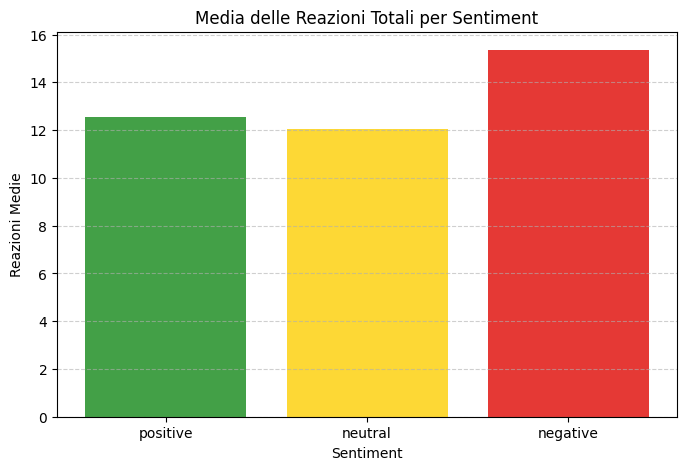

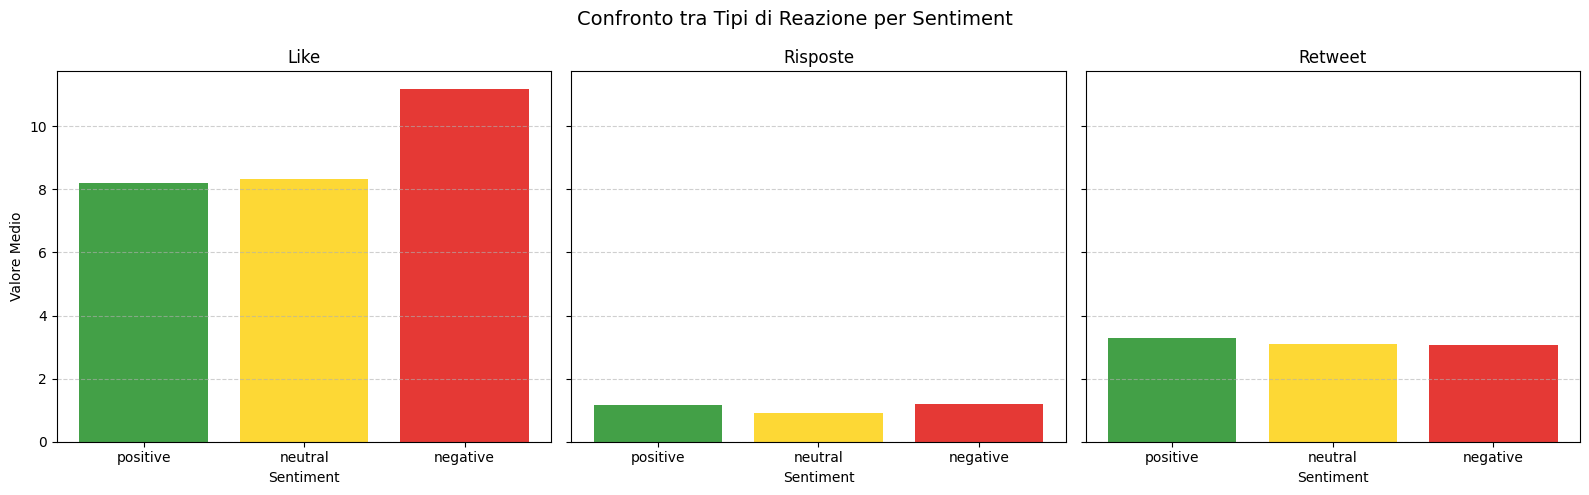

📊 Media delle reazioni per sentiment:


,sentiment,likes,replies,retweets,reactions
0,positive,8.19,1.17,3.28,12.56
1,neutral,8.32,0.90,3.09,12.04
2,negative,11.18,1.20,3.06,15.35


In [23]:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import pandas as pd

# 🔹 Cast esplicito a float per sicurezza
numeric_cols = ["likes_orig", "replies_orig", "retweets_orig", "reactions"]

df_all = df_project_data
for c in numeric_cols:
    df_all = df_all.withColumn(c, col(c).cast("float"))

# 🔹 Calcolo medie per tipo di sentiment (positive, negative, neutral)
agg_df = df_all.groupBy("sentiment").avg(*numeric_cols)

# 🔹 Conversione a Pandas
agg_pd = agg_df.toPandas().rename(columns={
    "avg(likes_orig)": "likes",
    "avg(replies_orig)": "replies",
    "avg(retweets_orig)": "retweets",
    "avg(reactions)": "reactions"
})

# 🔹 Ordine coerente (se esistono tutti e tre)
order = [s for s in ["positive", "neutral", "negative"] if s in agg_pd["sentiment"].values]
agg_pd = agg_pd.set_index("sentiment").loc[order].reset_index()

# === 1️⃣ Grafico media reazioni totali per tweet ===
plt.figure(figsize=(8,5))
plt.bar(agg_pd["sentiment"], agg_pd["reactions"], color=["#43A047", "#FDD835", "#E53935"])
plt.title("Media delle Reazioni Totali per Sentiment")
plt.xlabel("Sentiment")
plt.ylabel("Reazioni Medie")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

# === 2️⃣ Grafici comparativi per like, risposte e retweet ===
fig, axes = plt.subplots(1, 3, figsize=(16,5), sharey=True)

colors = {"positive": "#43A047", "neutral": "#FDD835", "negative": "#E53935"}
metrics = ["likes", "replies", "retweets"]
titles = ["Like", "Risposte", "Retweet"]

for ax, metric, title in zip(axes, metrics, titles):
    ax.bar(agg_pd["sentiment"], agg_pd[metric], color=[colors[s] for s in agg_pd["sentiment"]])
    ax.set_title(title)
    ax.set_xlabel("Sentiment")
    ax.grid(axis="y", linestyle="--", alpha=0.6)

axes[0].set_ylabel("Valore Medio")
fig.suptitle("Confronto tra Tipi di Reazione per Sentiment", fontsize=14)
plt.tight_layout()
plt.show()

# === 3️⃣ Tabella riassuntiva con valori arrotondati ===
print("📊 Media delle reazioni per sentiment:")
display(agg_pd.round(2))


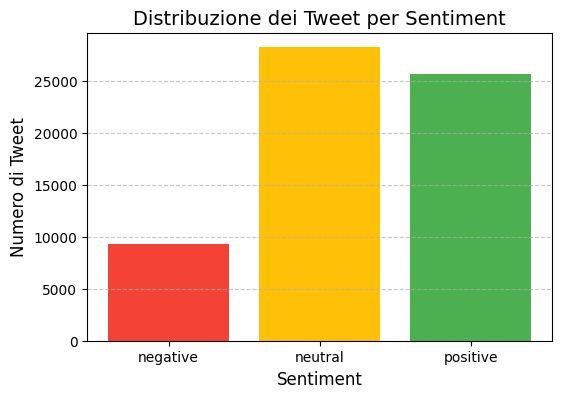

In [24]:
import matplotlib.pyplot as plt

# ✅ Conversione a pandas solo delle colonne necessarie
sentiment_df = (
    df_project_data
    .groupBy("sentiment")
    .count()
    .toPandas()
    .sort_values("sentiment")
)

# 🎨 Colori coerenti: verde = positivo, rosso = negativo, giallo = neutro
colors = {
    "positive": "#4CAF50",
    "negative": "#F44336",
    "neutral": "#FFC107"
}

# 📊 Grafico
plt.figure(figsize=(6, 4))
plt.bar(
    sentiment_df["sentiment"],
    sentiment_df["count"],
    color=[colors[s] for s in sentiment_df["sentiment"]]
)
plt.title("Distribuzione dei Tweet per Sentiment", fontsize=14)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Numero di Tweet", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


Osserviamo che, in media, un tweet con sentiment negativo attira meno reazioni rispetto a un tweet positivo, anche se la differenza tra le due medie è minima.

Nella cella sottostante sono riportati tre grafici:
- La scheda "likes" mostra il numero medio di like in base al sentiment;
- La scheda "replies" mostra il numero medio di risposte in base al sentiment;
- La scheda "retweets" mostra il numero medio di condivisioni in base al sentiment.

In sintesi, i tweet positivi tendono a generare un coinvolgimento più attivo da parte degli utenti (risposte e condivisioni), mentre i tweet negativi, pur essendo leggermente più numerosi, suscitano reazioni prevalentemente passive, come i like. Questo suggerisce che i contenuti ottimisti risultano più “partecipativi” nella community legata al Bitcoin.

## Panoramica generale

Il grafico di seguito ottenuto mostra l'andamento del prezzo medio nel tempo.

In [25]:
df_project_data.columns

['date',
 'timestamp',
 'sentiment',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions',
 'open_price',
 'close_price',
 'mean_price']

In [26]:
import plotly.graph_objects as go
from pyspark.sql.functions import avg
import pandas as pd

# --- 1️⃣ Calcolo prezzo medio giornaliero ---
price_df = (
    df_project_data.groupBy("date")
    .agg(avg("mean_price").alias("avg_mean_price"))
    .orderBy("date")
)

# --- 2️⃣ Conversione in Pandas ---
price_pd = price_df.toPandas()
price_pd["date"] = pd.to_datetime(price_pd["date"])

# --- 3️⃣ Punto massimo e minimo ---
max_row = price_pd.loc[price_pd["avg_mean_price"].idxmax()]
min_row = price_pd.loc[price_pd["avg_mean_price"].idxmin()]

# --- 4️⃣ Grafico Plotly ---
fig = go.Figure()

# Linea principale
fig.add_trace(go.Scatter(
    x=price_pd["date"],
    y=price_pd["avg_mean_price"],
    mode="lines",
    line=dict(color="#FF9800", width=2),
    name="Prezzo Medio (USD)",
    hovertemplate="📅 %{x|%d %b %Y}<br>💰 %{y:,.2f} USD<extra></extra>"
))

# Punto massimo
fig.add_trace(go.Scatter(
    x=[max_row["date"]],
    y=[max_row["avg_mean_price"]],
    mode="markers+text",
    text=[f"Max: {max_row['avg_mean_price']:.0f}"],
    textposition="top center",
    marker=dict(color="green", size=10, line=dict(color="black", width=1)),
    name="Massimo"
))

# Punto minimo
fig.add_trace(go.Scatter(
    x=[min_row["date"]],
    y=[min_row["avg_mean_price"]],
    mode="markers+text",
    text=[f"Min: {min_row['avg_mean_price']:.0f}"],
    textposition="bottom center",
    marker=dict(color="red", size=10, line=dict(color="black", width=1)),
    name="Minimo"
))

# --- Layout ---
fig.update_layout(
    title="Andamento del Prezzo Medio del Bitcoin nel Tempo",
    xaxis_title="Data",
    yaxis_title="Prezzo Medio (USD)",
    template="plotly_white",
    hovermode="x unified",
    height=500,
    xaxis=dict(
        tickformat="%b %Y",
        tickangle=45,
        dtick="M2"
    ),
    legend=dict(yanchor="top", y=0.98, xanchor="left", x=0.01)
)

fig.show()


Osserviamo una crescita esponenziale del prezzo del Bitcoin fino a dicembre 2017, seguito da un calo fino al minimo del prezzo raggiunto tra dicembre 2018 e marzo 2019.

In modo analogo, è stato tracciato un grafico che mostra il numero di tweet nel tempo e un grafico mensile per rispondere esattamente al feedback “raggruppa su base mensile. Per facilitare la lettura del grafico, si è deciso di utilizzare una scala logaritmica.

Andamento temporale del numero di tweet contenenti riferimenti al Bitcoin.
La scala logaritmica consente di evidenziare meglio le variazioni nei periodi con un volume di attività molto diverso

In [27]:
df_project_data.columns

['date',
 'timestamp',
 'sentiment',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions',
 'open_price',
 'close_price',
 'mean_price']

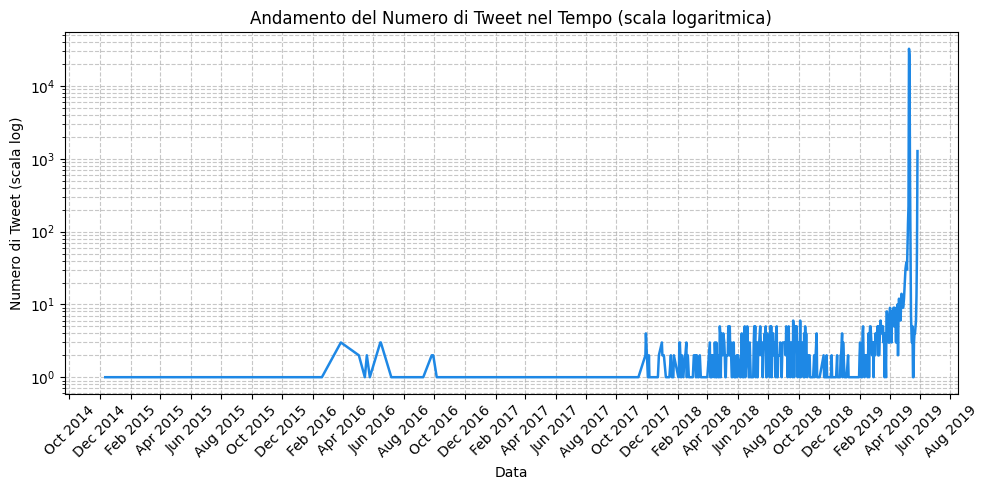

In [28]:
import matplotlib.dates as mdates
# 🔹 Aggregazione dei tweet per giorno
tweets_df = (
    df_project_data.groupBy("date")
    .agg(count("*").alias("tweet_count"))
    .orderBy("date")
)

# 🔹 Conversione a Pandas e formato data
tweets_pd = tweets_df.toPandas()
tweets_pd["date"] = pd.to_datetime(tweets_pd["date"])

# 🔹 Grafico con scala logaritmica
plt.figure(figsize=(10,5))
plt.plot(tweets_pd["date"], tweets_pd["tweet_count"], color="#1E88E5", linewidth=1.8)

plt.yscale("log")
plt.title("Andamento del Numero di Tweet nel Tempo (scala logaritmica)")
plt.xlabel("Data")
plt.ylabel("Numero di Tweet (scala log)")
plt.grid(True, which="both", linestyle="--", alpha=0.7)

# 🔹 Asse X formattato con mesi
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


In [29]:
import plotly.graph_objects as go
from pyspark.sql.functions import count

# --- 1️⃣ Aggregazione ---
tweets_df = (
    df_project_data.groupBy("date")
    .agg(count("*").alias("tweet_count"))
    .orderBy("date")
)

tweets_pd = tweets_df.toPandas()
tweets_pd["date"] = pd.to_datetime(tweets_pd["date"])

# --- 2️⃣ Grafico Plotly ---
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=tweets_pd["date"],
    y=tweets_pd["tweet_count"],
    mode="lines",
    line=dict(color="#1E88E5", width=2),
    hovertemplate="📅 %{x|%b %Y}<br>Tweet: %{y:,}<extra></extra>",
    name="Numero di Tweet"
))

# --- 3️⃣ Layout ---
fig.update_layout(
    title="Andamento del Numero di Tweet nel Tempo (scala logaritmica)",
    xaxis_title="Data",
    yaxis=dict(title="Numero di Tweet (scala log)", type="log"),
    template="plotly_white",
    hovermode="x unified",
    height=500,
    xaxis=dict(
        tickformat="%b %Y",
        tickangle=45
    )
)

# 🔹 Opzionale: aggiungi uno slider temporale interattivo
fig.update_layout(
    xaxis=dict(
        rangeslider=dict(visible=True),
        rangeselector=dict(
            buttons=list([
                dict(count=6, label="6M", step="month", stepmode="backward"),
                dict(count=1, label="1Y", step="year", stepmode="backward"),
                dict(step="all", label="Tutti")
            ])
        )
    )
)

fig.show()


 ### Grafico focus andamento tweet solo nel 2019

Il grafico mostra l’andamento giornaliero del numero di tweet relativi al Bitcoin nel corso del 2019, rappresentato in scala logaritmica. Sono evidenziati i giorni con il valore massimo e minimo di attività sulla piattaforma.

In [30]:
df_project_data.columns

['date',
 'timestamp',
 'sentiment',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions',
 'open_price',
 'close_price',
 'mean_price']

In [31]:
import plotly.graph_objects as go
from pyspark.sql.functions import count
import pandas as pd

# --- 1️⃣ Aggregazione ---
tweets_df = df_project_data.groupBy("date").agg(count("*").alias("tweet_count")).orderBy("date")
tweets_pd = tweets_df.toPandas()
tweets_pd["date"] = pd.to_datetime(tweets_pd["date"])

# --- 2️⃣ Filtro solo 2019 ---
tweets_2019 = tweets_pd[
    (tweets_pd["date"] >= "2019-01-01") & (tweets_pd["date"] <= "2019-12-31")
]

# --- 3️⃣ Trova massimo ---
max_row = tweets_2019.loc[tweets_2019["tweet_count"].idxmax()]

# --- 4️⃣ Grafico Plotly ---
fig = go.Figure()

# Linea principale
fig.add_trace(go.Scatter(
    x=tweets_2019["date"],
    y=tweets_2019["tweet_count"],
    mode="lines",
    line=dict(color="#43A047", width=2),
    name="Tweet/giorno",
    hovertemplate="📅 %{x|%d %b %Y}<br>Tweet: %{y:,}<extra></extra>"
))

# Punto massimo
fig.add_trace(go.Scatter(
    x=[max_row["date"]],
    y=[max_row["tweet_count"]],
    mode="markers+text",
    text=[f"Max: {max_row['tweet_count']:,}"],
    textposition="top center",
    marker=dict(color="red", size=10, line=dict(color="black", width=1)),
    name="Massimo"
))

# --- Layout ---
fig.update_layout(
    title="Andamento del Numero di Tweet nel 2019 (Scala Logaritmica)",
    xaxis_title="Data",
    yaxis=dict(title="Numero di Tweet (scala log)", type="log"),
    template="plotly_white",
    hovermode="x unified",
    height=500,
    xaxis=dict(
        tickformat="%b %Y",
        tickangle=45,
        dtick="M1"
    ),
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01)
)

fig.show()


Il grafico mostra l’andamento mensile del numero di tweet classificati per sentiment (positivo, neutro, negativo). La scala logaritmica consente di visualizzare in modo chiaro le variazioni anche nei periodi con volumi di tweet molto diversi. I punti evidenziati indicano i mesi con il picco massimo per ciascuna categoria di sentiment.

In [32]:
df_project_data.columns

['date',
 'timestamp',
 'sentiment',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions',
 'open_price',
 'close_price',
 'mean_price']

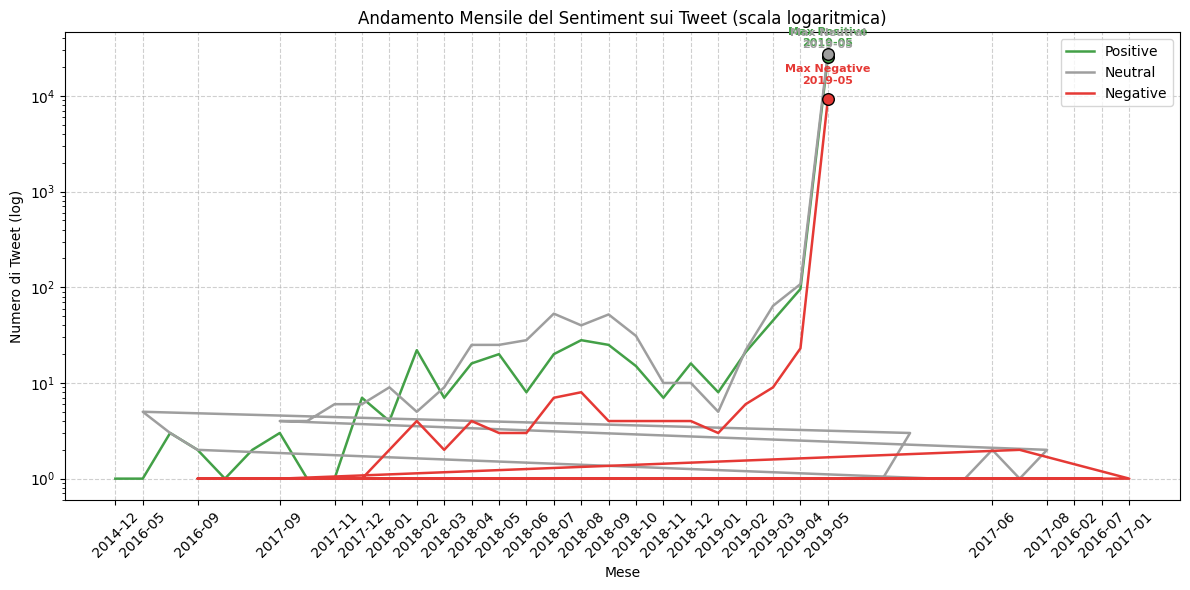

In [33]:
from pyspark.sql.functions import date_format, col, to_date
import matplotlib.pyplot as plt
import pandas as pd

# ✅ Usiamo df_project_data, che ha la colonna 'date'
df = df_project_data.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

# Raggruppamento mensile per sentiment
df_monthly = (
    df.groupBy(date_format(col("date"), "yyyy-MM").alias("month"), "sentiment")
      .count()
      .orderBy("month")
)

# Conversione in Pandas
df_monthly_pd = df_monthly.toPandas()

# Grafico
plt.figure(figsize=(12,6))

colors = {
    "positive": "#43A047",
    "neutral": "#9E9E9E",
    "negative": "#E53935"
}

for sentiment in ["positive", "neutral", "negative"]:
    subset = df_monthly_pd[df_monthly_pd["sentiment"] == sentiment]
    plt.plot(subset["month"], subset["count"], label=sentiment.capitalize(),
             color=colors[sentiment], linewidth=1.8)

    # Evidenzia massimo
    if not subset.empty:
        max_idx = subset["count"].idxmax()
        max_point = subset.loc[max_idx]
        plt.scatter(max_point["month"], max_point["count"], color=colors[sentiment],
                    s=70, edgecolor="black", zorder=5)
        y_offset = 1.3 if sentiment == "positive" else (1.15 if sentiment == "neutral" else 1.45)
        plt.text(max_point["month"], max_point["count"] * y_offset,
                 f"Max {sentiment.capitalize()}\n{max_point['month']}",
                 ha="center", fontsize=8, color=colors[sentiment], weight="bold")

plt.yscale("log")
plt.title("Andamento Mensile del Sentiment sui Tweet (scala logaritmica)")
plt.xlabel("Mese")
plt.ylabel("Numero di Tweet (log)")
plt.xticks(df_monthly_pd["month"][::3], rotation=45)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()



In [34]:
import plotly.graph_objects as go
from pyspark.sql.functions import date_format, col, to_date

# --- 1️⃣ Prepara i dati ---
df = df_project_data.withColumn("date", to_date(col("date"), "yyyy-MM-dd"))

df_monthly = (
    df.groupBy(date_format(col("date"), "yyyy-MM").alias("month"), "sentiment")
      .count()
      .orderBy("month")
)

df_monthly_pd = df_monthly.toPandas()

# --- 2️⃣ Colori e setup ---
colors = {
    "positive": "#43A047",
    "neutral": "#9E9E9E",
    "negative": "#E53935"
}

fig = go.Figure()

# --- 3️⃣ Tracce per ogni sentiment ---
for sentiment in ["positive", "neutral", "negative"]:
    subset = df_monthly_pd[df_monthly_pd["sentiment"] == sentiment]
    if subset.empty:
        continue

    # Linea principale
    fig.add_trace(go.Scatter(
        x=subset["month"],
        y=subset["count"],
        mode="lines+markers",
        name=sentiment.capitalize(),
        line=dict(color=colors[sentiment], width=2),
        hovertemplate="📅 %{x}<br>Tweet: %{y:,}<extra></extra>"
    ))

    # Punto massimo
    max_idx = subset["count"].idxmax()
    max_point = subset.loc[max_idx]
    fig.add_trace(go.Scatter(
        x=[max_point["month"]],
        y=[max_point["count"]],
        mode="markers+text",
        text=[f"🔹 Max {sentiment.capitalize()}"],
        textposition="top center",
        marker=dict(color=colors[sentiment], size=10, line=dict(color="black", width=1)),
        showlegend=False,
        hoverinfo="skip"
    ))

# --- 4️⃣ Layout finale ---
fig.update_layout(
    title="Andamento Mensile del Sentiment sui Tweet (scala logaritmica)",
    xaxis_title="Mese",
    yaxis=dict(
        title="Numero di Tweet (log)",
        type="log"
    ),
    legend=dict(x=0.02, y=0.98, bgcolor="rgba(0,0,0,0)"),
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()


Si osserva che la crescita effettiva del numero di tweet è iniziata dopo il 2017 e che si è raggiunto un picco nel maggio 2019, in corrispondenza alla risalita del prezzo nel grafico precedente. La relazione tra queste variabili sarà esplorata nella sezione dedicata alla panoramica temporale.

Il grafico a barre seguente mostra la media del numero di tweet per fascia oraria.

In [35]:
df_project_data.columns

['date',
 'timestamp',
 'sentiment',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions',
 'open_price',
 'close_price',
 'mean_price']

In [36]:

from pyspark.sql.functions import hour, col, concat, lit, count, mean


In [37]:
from pyspark.sql.functions import hour, format_string, col

# Estrai ora intera dal timestamp da df_project_data (che include già BTC)
df_hours = df_project_data.withColumn("hour", hour(col("timestamp")))

# Fascia oraria da 1h (es: 09:00–09:59)
df_hours = df_hours.withColumn(
    "time_slot",
    format_string("%02d:00–%02d:59", col("hour"), col("hour"))
)

df_hours.select("timestamp", "hour", "time_slot").show(10)



+-------------------+----+-----------+
|          timestamp|hour|  time_slot|
+-------------------+----+-----------+
|2016-02-19 08:44:38|   8|08:00–08:59|
|2016-03-28 03:30:33|   3|03:00–03:59|
|2016-03-28 06:43:16|   6|06:00–06:59|
|2016-05-03 03:41:45|   3|03:00–03:59|
|2016-05-15 21:28:01|  21|21:00–21:59|
|2016-05-19 03:38:59|   3|03:00–03:59|
|2016-05-25 03:58:07|   3|03:00–03:59|
|2016-06-15 04:05:48|   4|04:00–04:59|
|2016-06-15 06:29:21|   6|06:00–06:59|
|2016-06-16 03:55:05|   3|03:00–03:59|
+-------------------+----+-----------+
only showing top 10 rows



In [38]:
df_project_data = df_hours.filter(col("hour").isNotNull())


In [39]:
df_project_data.columns

['date',
 'timestamp',
 'sentiment',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions',
 'open_price',
 'close_price',
 'mean_price',
 'hour',
 'time_slot']

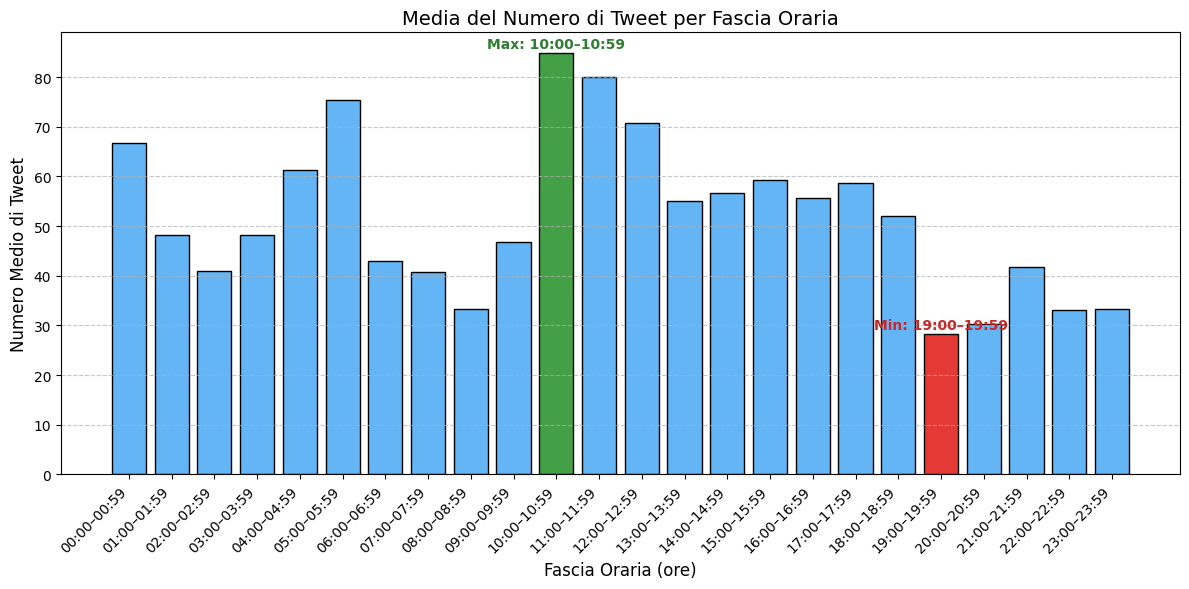

In [40]:
from pyspark.sql.functions import count, avg, col
import matplotlib.pyplot as plt

# 🔹 Filtra righe con time_slot valido
df_project_data = df_project_data.filter(col("time_slot").isNotNull())

# --- 1️⃣ Calcolo del numero medio di tweet per fascia oraria ---
hourly_tweets_df = (
    df_project_data
    .groupBy("date", "time_slot")
    .agg(count("*").alias("tweet_count"))
    .groupBy("time_slot")
    .agg(avg("tweet_count").alias("avg_tweets"))
    .orderBy("time_slot")
)

hourly_tweets_pd = hourly_tweets_df.toPandas()

# --- 2️⃣ Ordina le fasce orarie in ordine cronologico ---
hourly_tweets_pd["slot_order"] = hourly_tweets_pd["time_slot"].str.split(":").str[0].astype(int)
hourly_tweets_pd = hourly_tweets_pd.sort_values("slot_order").reset_index(drop=True)

# --- 3️⃣ Trova massimo e minimo ---
max_idx = hourly_tweets_pd["avg_tweets"].idxmax()
min_idx = hourly_tweets_pd["avg_tweets"].idxmin()

# --- 4️⃣ Colori: base azzurro, massimo verde, minimo rosso ---
colors = ["#64B5F6"] * len(hourly_tweets_pd)
colors[max_idx] = "#43A047"  # verde per massimo
colors[min_idx] = "#E53935"  # rosso per minimo

# --- 5️⃣ Grafico ---
plt.figure(figsize=(12,6))
plt.bar(hourly_tweets_pd["time_slot"], hourly_tweets_pd["avg_tweets"], color=colors, edgecolor="black")
plt.title("Media del Numero di Tweet per Fascia Oraria", fontsize=14)
plt.xlabel("Fascia Oraria (ore)", fontsize=12)
plt.ylabel("Numero Medio di Tweet", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45, ha="right")

# Annotazioni per massimo e minimo
plt.text(max_idx, hourly_tweets_pd["avg_tweets"][max_idx] + 0.5,
         f"Max: {hourly_tweets_pd['time_slot'][max_idx]}",
         ha='center', va='bottom', color="#2E7D32", fontweight='bold')
plt.text(min_idx, hourly_tweets_pd["avg_tweets"][min_idx] + 0.5,
         f"Min: {hourly_tweets_pd['time_slot'][min_idx]}",
         ha='center', va='bottom', color="#C62828", fontweight='bold')

plt.tight_layout()
plt.show()



In media, il maggior numero di tweet viene pubblicato tra le 10 e 11, in corrispondenza della metà della giornata di operazioni in borsa, mentre il minore numero viene pubblicato tra le 19 e le 20, ossia dopo la chiusura delle borse.

# Panoramica storica

In questa sezione si analizzerà la relazione tra il sentiment e il prezzo in funzione del tempo. Si premette che, dato il diverso ordine di grandezza di queste variabili, si è scelto di utilizzare una scala logaritmica per agevolare la lettura del grafico.

Il grafico sottostante mostra l'andamento del numero di tweet (in blu) e del prezzo medio (in verde chiaro) in funzione dei mesi.


In [41]:
df_project_data.printSchema()


root
 |-- date: date (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- likes_orig: string (nullable = true)
 |-- replies_orig: string (nullable = true)
 |-- retweets_orig: string (nullable = true)
 |-- reactions: double (nullable = true)
 |-- open_price: double (nullable = true)
 |-- close_price: double (nullable = true)
 |-- mean_price: double (nullable = true)
 |-- hour: integer (nullable = true)
 |-- time_slot: string (nullable = false)



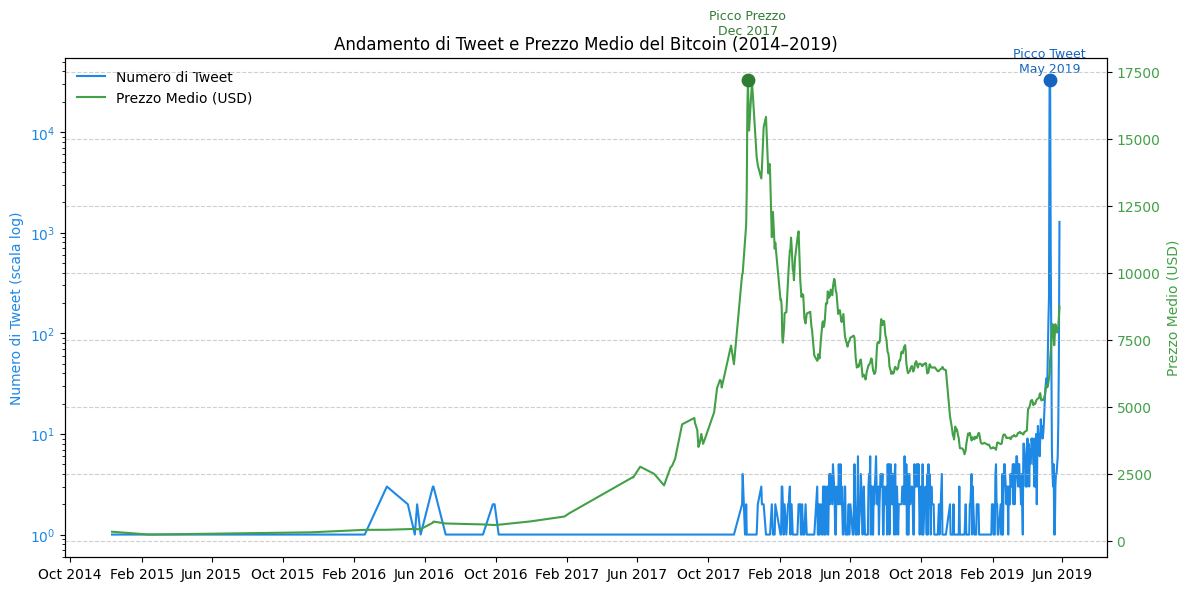

In [42]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from pyspark.sql.functions import count, avg

# 🔹 Raggruppamento per data
df_trend = (
    df_project_data
    .groupBy("date")
    .agg(
        count("*").alias("tweet_count"),
        avg("mean_price").alias("avg_price")   # usa la colonna prezzo medio già presente
    )
    .orderBy("date")
)

# Conversione in Pandas
df_pd = df_trend.toPandas()
df_pd["date"] = pd.to_datetime(df_pd["date"])

# --- Grafico ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Linea Tweet
ax1.plot(df_pd["date"], df_pd["tweet_count"], color="#1E88E5", label="Numero di Tweet")
ax1.set_ylabel("Numero di Tweet (scala log)", color="#1E88E5")
ax1.set_yscale("log")
ax1.tick_params(axis="y", labelcolor="#1E88E5")

# Linea Prezzo Medio
ax2 = ax1.twinx()
ax2.plot(df_pd["date"], df_pd["avg_price"], color="#43A047", label="Prezzo Medio (USD)")
ax2.set_ylabel("Prezzo Medio (USD)", color="#43A047")
ax2.tick_params(axis="y", labelcolor="#43A047")

# Format asse X
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=4))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.xticks(rotation=30)

# 🔹 Picchi
max_tweet = df_pd.loc[df_pd["tweet_count"].idxmax()]
max_price = df_pd.loc[df_pd["avg_price"].idxmax()]

ax1.scatter(max_tweet["date"], max_tweet["tweet_count"], color="#1565C0", s=80, zorder=5)
ax1.text(max_tweet["date"], max_tweet["tweet_count"]*1.2,
         f"Picco Tweet\n{max_tweet['date'].strftime('%b %Y')}",
         color="#1565C0", ha="center", fontsize=9)

ax2.scatter(max_price["date"], max_price["avg_price"], color="#2E7D32", s=80, zorder=5)
ax2.text(max_price["date"], max_price["avg_price"]*1.1,
         f"Picco Prezzo\n{max_price['date'].strftime('%b %Y')}",
         color="#2E7D32", ha="center", fontsize=9)

# Legenda e titolo automatico
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper left", frameon=False)

periodo = f"{df_pd['date'].min().strftime('%Y')}–{df_pd['date'].max().strftime('%Y')}"
plt.title(f"Andamento di Tweet e Prezzo Medio del Bitcoin ({periodo})")
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


In [43]:
import plotly.graph_objects as go
import pandas as pd
from pyspark.sql.functions import count, avg

# --- 1️⃣ Raggruppamento per data ---
df_trend = (
    df_project_data
    .groupBy("date")
    .agg(
        count("*").alias("tweet_count"),
        avg("mean_price").alias("avg_price")
    )
    .orderBy("date")
)

# --- 2️⃣ Conversione in Pandas ---
df_pd = df_trend.toPandas()
df_pd["date"] = pd.to_datetime(df_pd["date"])

# --- 3️⃣ Trova i picchi ---
max_tweet = df_pd.loc[df_pd["tweet_count"].idxmax()]
max_price = df_pd.loc[df_pd["avg_price"].idxmax()]

# --- 4️⃣ Figura Plotly ---
fig = go.Figure()

# Linea Tweet
fig.add_trace(go.Scatter(
    x=df_pd["date"],
    y=df_pd["tweet_count"],
    name="Numero di Tweet",
    mode="lines",
    line=dict(color="#1E88E5", width=2),
    yaxis="y1",
    hovertemplate="📅 %{x|%b %Y}<br>Tweet: %{y:,}"
))

# Linea Prezzo
fig.add_trace(go.Scatter(
    x=df_pd["date"],
    y=df_pd["avg_price"],
    name="Prezzo Medio (USD)",
    mode="lines",
    line=dict(color="#43A047", width=2, dash="dash"),
    yaxis="y2",
    hovertemplate="📅 %{x|%b %Y}<br>Prezzo: $%{y:,.0f}"
))

# --- 5️⃣ Marker Picchi ---
fig.add_trace(go.Scatter(
    x=[max_tweet["date"]],
    y=[max_tweet["tweet_count"]],
    mode="markers+text",
    text=["📈 Picco Tweet"],
    textposition="top center",
    marker=dict(color="#1565C0", size=10),
    name="Picco Tweet",
    yaxis="y1"
))

fig.add_trace(go.Scatter(
    x=[max_price["date"]],
    y=[max_price["avg_price"]],
    mode="markers+text",
    text=["💰 Picco Prezzo"],
    textposition="top center",
    marker=dict(color="#2E7D32", size=10),
    name="Picco Prezzo",
    yaxis="y2"
))

# --- 6️⃣ Layout ---
periodo = f"{df_pd['date'].min().year}–{df_pd['date'].max().year}"

fig.update_layout(
    title=f"Andamento di Tweet e Prezzo Medio del Bitcoin ({periodo})",
    xaxis=dict(title="Data", tickformat="%b %Y"),
    yaxis=dict(
        title="Numero di Tweet (log)",
        type="log",
        titlefont=dict(color="#1E88E5"),
        tickfont=dict(color="#1E88E5")
    ),
    yaxis2=dict(
        title="Prezzo Medio (USD)",
        titlefont=dict(color="#43A047"),
        tickfont=dict(color="#43A047"),
        anchor="x",
        overlaying="y",
        side="right"
    ),
    legend=dict(x=0.01, y=0.99, bgcolor="rgba(0,0,0,0)"),
    hovermode="x unified",
    template="plotly_white",
    height=600
)

fig.show()


Come già anticipato nella precedente sezione, il numero di tweet sul Bitcoin è cresciuto insieme al prezzo e ha continuato a salire anche in seguito al crollo tra gennaio e settembre 2018. Dopo quella data, i due grafici hanno ripreso ad andare quasi di pari passo.


Il grafico seguente mostra il sentiment medio dei tweet in base alla fascia oraria.

In [44]:
df_sentiment_full.columns


['id',
 'timestamp',
 'replies',
 'likes',
 'retweets',
 'lemmatized_text',
 'sentiment',
 'date',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions']

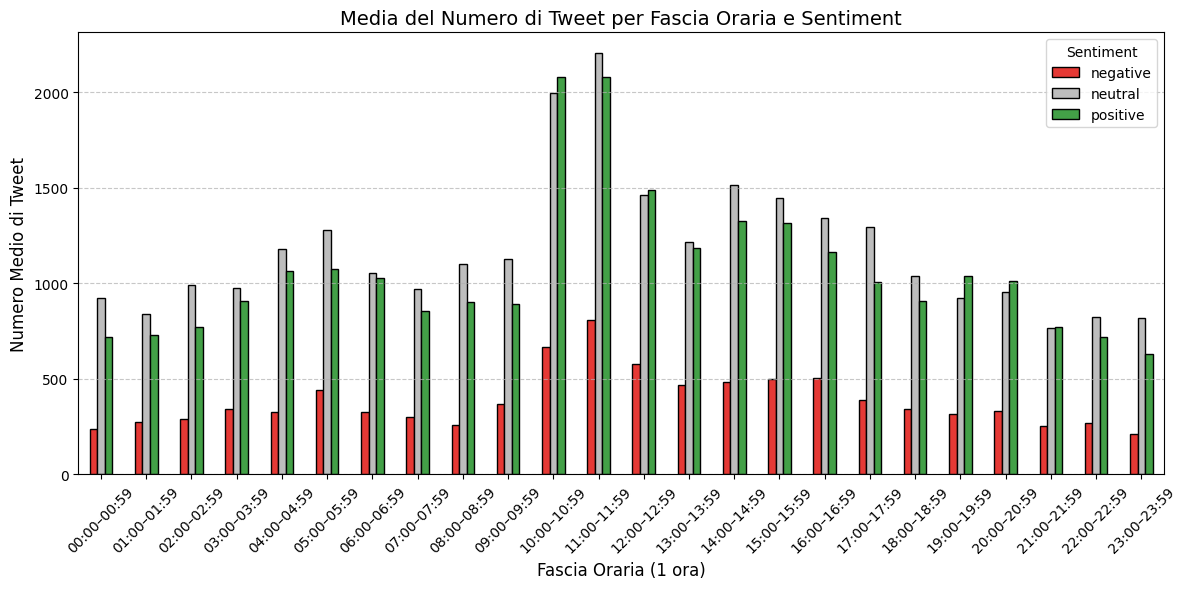

In [45]:
from pyspark.sql.functions import hour, col, concat, lit, count, mean, lpad
import matplotlib.pyplot as plt

# --- 1️⃣ Crea le colonne 'hour' e 'time_slot' ---
df_project_data = (
    df_sentiment_full
    .withColumn("hour", hour(col("timestamp")))
    .withColumn(
        "time_slot",
        concat(
            lpad(col("hour").cast("string"), 2, "0"),
            lit(":00–"),
            lpad(col("hour").cast("string"), 2, "0"),
            lit(":59")
        )
    )
)

# 🔹 Filtra righe senza ora valida
df_project_data = df_project_data.filter(col("hour").isNotNull())

# --- 2️⃣ Calcolo media tweet per fascia oraria e sentiment ---
sentiment_time = (
    df_project_data
    .groupBy("time_slot", "sentiment")
    .agg(count("*").alias("tweet_count"))
    .groupBy("time_slot", "sentiment")
    .agg(mean("tweet_count").alias("mean_count"))
    .orderBy("time_slot")
)

# --- 3️⃣ Conversione in Pandas ---
sentiment_time_pd = sentiment_time.toPandas()

# Pivot per avere sentiment come colonne
sentiment_pivot = sentiment_time_pd.pivot(
    index="time_slot",
    columns="sentiment",
    values="mean_count"
).fillna(0)

# --- 4️⃣ Grafico ---
sentiment_pivot.plot(
    kind="bar",
    figsize=(12,6),
    color={"positive": "#43A047", "neutral": "#BDBDBD", "negative": "#E53935"},
    edgecolor="black"
)

plt.title("Media del Numero di Tweet per Fascia Oraria e Sentiment", fontsize=14)
plt.xlabel("Fascia Oraria (1 ora)", fontsize=12)
plt.ylabel("Numero Medio di Tweet", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Sentiment", loc="upper right")
plt.tight_layout()
plt.show()




Il grafico illustra la media giornaliera del numero di tweet per ciascuna fascia oraria, suddivisi secondo sentiment (positivo, neutro, negativo). Le fasce orarie sono espresse in intervalli di un’ora. L’analisi consente di identificare i momenti della giornata in cui predominano determinate polarità del sentimento nella discussione su Twitter.La tendenza generale è una prevalenza di tweet neutrali per la maggior parte della giornata. Picchi dei tweet dalle 9:00 - 12 :00.

Nei tre grafici seguenti, si mostra la suddivisione in fascia oraria in base al sentiment.


/tmp/ipython-input-2317689609.py:48: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-2317689609.py:54: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/tmp/ipython-input-2317689609.py:60: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



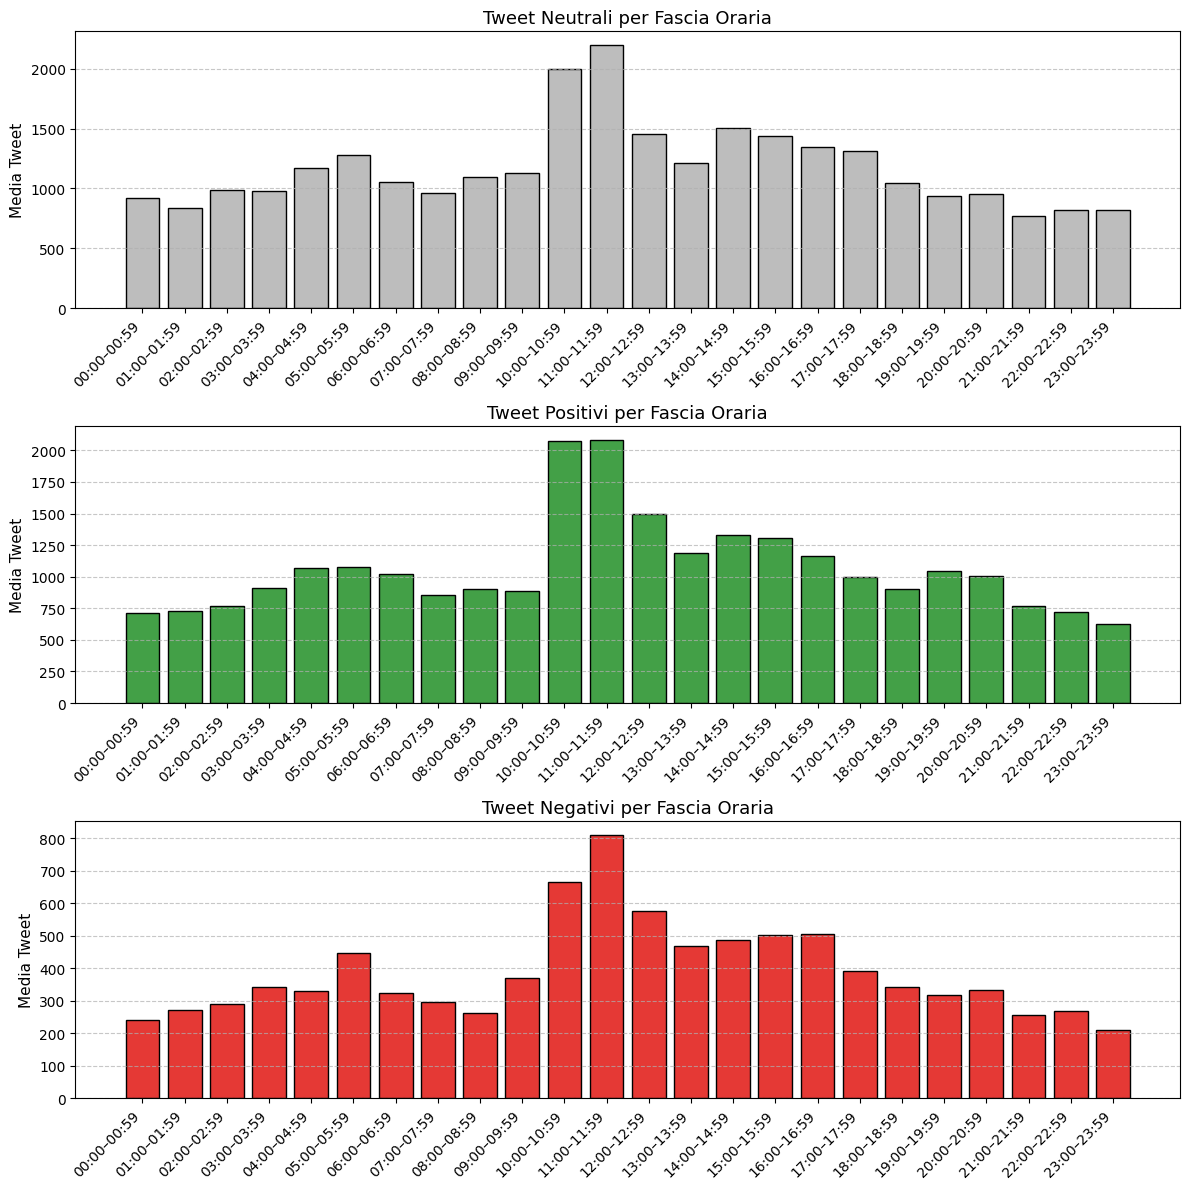

In [46]:
from pyspark.sql.functions import col, count, mean
import matplotlib.pyplot as plt

# 🔹 Escludi eventuali righe senza fascia oraria
df_project_data = df_project_data.filter(col("time_slot").isNotNull())

# --- 1️⃣ Calcolo medio per ciascun sentiment ---
neutral_df = (
    df_project_data.filter(col("sentiment") == "neutral")
    .groupBy("time_slot")
    .agg(count("*").alias("tweet_count"))
    .groupBy("time_slot")
    .agg(mean("tweet_count").alias("mean_count"))
)

positive_df = (
    df_project_data.filter(col("sentiment") == "positive")
    .groupBy("time_slot")
    .agg(count("*").alias("tweet_count"))
    .groupBy("time_slot")
    .agg(mean("tweet_count").alias("mean_count"))
)

negative_df = (
    df_project_data.filter(col("sentiment") == "negative")
    .groupBy("time_slot")
    .agg(count("*").alias("tweet_count"))
    .groupBy("time_slot")
    .agg(mean("tweet_count").alias("mean_count"))
)

# --- 2️⃣ Conversione in Pandas e ordinamento ---
def sort_slots(df):
    df["slot_order"] = df["time_slot"].str.split(":").str[0].astype(int)
    return df.sort_values("slot_order")

neutral_pd = sort_slots(neutral_df.toPandas())
positive_pd = sort_slots(positive_df.toPandas())
negative_pd = sort_slots(negative_df.toPandas())

# --- 3️⃣ Grafici separati ---
fig, axes = plt.subplots(3, 1, figsize=(12, 12))

axes[0].bar(neutral_pd["time_slot"], neutral_pd["mean_count"], color="#BDBDBD", edgecolor="black")
axes[0].set_title("Tweet Neutrali per Fascia Oraria", fontsize=13)
axes[0].set_ylabel("Media Tweet", fontsize=11)
axes[0].grid(axis="y", linestyle="--", alpha=0.7)
axes[0].set_xticklabels(neutral_pd["time_slot"], rotation=45, ha="right")

axes[1].bar(positive_pd["time_slot"], positive_pd["mean_count"], color="#43A047", edgecolor="black")
axes[1].set_title("Tweet Positivi per Fascia Oraria", fontsize=13)
axes[1].set_ylabel("Media Tweet", fontsize=11)
axes[1].grid(axis="y", linestyle="--", alpha=0.7)
axes[1].set_xticklabels(positive_pd["time_slot"], rotation=45, ha="right")

axes[2].bar(negative_pd["time_slot"], negative_pd["mean_count"], color="#E53935", edgecolor="black")
axes[2].set_title("Tweet Negativi per Fascia Oraria", fontsize=13)
axes[2].set_ylabel("Media Tweet", fontsize=11)
axes[2].grid(axis="y", linestyle="--", alpha=0.7)
axes[2].set_xticklabels(negative_pd["time_slot"], rotation=45, ha="right")

plt.tight_layout()
plt.show()



Distribuzione media dei tweet per fascia oraria, suddivisi per sentimento.
I grafici mostrano come varia la frequenza media dei tweet con sentiment neutrale (grigio), positivo (verde) e negativo (rosso) nelle diverse fasce orarie. Dai grafici appena mostrati possiamo dedurre che:

-Il picco di tweet neutrali viene osservato tra le 10 alle 13 del mattino

-Tweet positivi e negativi: entrambi raggiungono il massimo a metà giornata di contrattazioni, tra le 11:00 e le 12:00, suggerendo che si tratti di tweet “checkpoint” utilizzati per commentare l’andamento intermedio del mercato.

-Fascia serale: si registra il minimo per i tweet neutrali e negativi, un comportamento che porta a ipotizzare la presenza prevalente di messaggi riepilogativi pubblicati a fine giornata
   

###📈 1️⃣ Andamento annuale sentiment vs prezzo medio

In [47]:
from pyspark.sql.functions import to_timestamp, hour, col, concat, lit, lpad
# ricontrolla che df_sentiment_full e df_btc esistano nella sessione

# 1) selezione tweet includendo timestamp
tweets_cols = [
    "date",
    "id",
    "timestamp",        # <-- importante includerla
    "sentiment",
    "likes_orig",
    "replies_orig",
    "retweets_orig",
    "reactions"
]

btc_cols = [
    "date",
    "open_price",
    "close_price",
    "mean_price"
]

# 2) ricrea la join su date (inner = solo righe con prezzo)
df_project_data = df_sentiment_full.select(*tweets_cols).join(
    df_btc.select(*btc_cols),
    on="date",
    how="inner"
)

# 3) assicurati che timestamp sia di tipo timestamp (se era string)
df_project_data = df_project_data.withColumn("timestamp", to_timestamp(col("timestamp")))

# 4) estrai hour e crea time_slot (fasce 1h), usando lpad per avere 2 cifre
df_project_data = df_project_data.withColumn("hour", hour(col("timestamp")))

df_project_data = df_project_data.withColumn(
    "time_slot",
    concat(
        lpad(col("hour").cast("string"), 2, "0"),
        lit(":00–"),
        lpad(col("hour").cast("string"), 2, "0"),
        lit(":59")
    )
)

# 5) rimuovi righe senza hour valido
df_project_data = df_project_data.filter(col("hour").isNotNull())

# 6) verifica risultato
print("Colonne in df_project_data:")
print(df_project_data.columns)
df_project_data.select("date", "id", "timestamp", "hour", "time_slot", "open_price", "close_price", "mean_price").show(5, truncate=False)



Colonne in df_project_data:
['date', 'id', 'timestamp', 'sentiment', 'likes_orig', 'replies_orig', 'retweets_orig', 'reactions', 'open_price', 'close_price', 'mean_price', 'hour', 'time_slot']
+----------+---------------------+-------------------+----+-----------+------------------+-----------------+----------+
|date      |id                   |timestamp          |hour|time_slot  |open_price        |close_price      |mean_price|
+----------+---------------------+-------------------+----+-----------+------------------+-----------------+----------+
|2016-02-19|7.006169741921485e+17|2016-02-19 08:44:38|8   |08:00–08:59|422.7300109863281 |420.7850036621094|421.76    |
|2016-03-28|7.14323772233257e+17 |2016-03-28 03:30:33|3   |03:00–03:59|426.5480041503906 |424.2309875488281|425.39    |
|2016-03-28|7.143722730423828e+17|2016-03-28 06:43:16|6   |06:00–06:59|426.5480041503906 |424.2309875488281|425.39    |
|2016-05-03|7.273725529395364e+17|2016-05-03 03:41:45|3   |03:00–03:59|444.726989746093

In [48]:
df_project_data.columns

['date',
 'id',
 'timestamp',
 'sentiment',
 'likes_orig',
 'replies_orig',
 'retweets_orig',
 'reactions',
 'open_price',
 'close_price',
 'mean_price',
 'hour',
 'time_slot']

In [49]:
from pyspark.sql.functions import year, avg

# 🔹 Raggruppamento per anno e sentiment
yearly_sentiment = (
    df_sentiment_clean.groupBy(year("date").alias("year"), "sentiment")
    .agg(avg("reactions").alias("avg_reactions"))
)

# 🔹 Conteggio totale dei tweet per anno
yearly_counts = (
    df_sentiment_clean.groupBy(year("date").alias("year"))
    .count()
    .withColumnRenamed("count", "total_tweets")
)

# 🔹 Join tra i due per calcolare le proporzioni
yearly_combined = (
    yearly_sentiment.join(yearly_counts, "year", "inner")
    .withColumn("ratio", col("avg_reactions") / col("total_tweets"))
)

# 🔹 Pivot per avere colonne separate per sentiment
yearly_pivot = (
    yearly_combined.groupBy("year")
    .pivot("sentiment", ["positive", "negative", "neutral"])
    .agg(avg("ratio"))
)

# 🔹 Join con il prezzo medio (già in df_btc)
from pyspark.sql.functions import avg as _avg

yearly_price = (
    df_btc.groupBy(year("date").alias("year"))
    .agg(_avg("mean_price").alias("avg_price"))
)

# 🔹 Join finale
yearly_df = yearly_pivot.join(yearly_price, "year", "inner").orderBy("year")

# 🔹 Conversione in Pandas per Plotly
yearly_pd = yearly_df.toPandas()

# 🔹 Controllo anteprima
yearly_pd.head()


,year,positive,negative,neutral,avg_price
0,2014,0.166667,NaN,0.000000,351.240444
1,2015,NaN,NaN,135.500000,272.301068
2,2016,0.006944,0.000000,0.180556,567.817077
3,2017,2.100709,7.652482,5.580196,3988.339205
4,2018,0.298526,0.245027,0.170710,7586.659096


In [50]:
print(yearly_pd.columns)


Index(['year', 'positive', 'negative', 'neutral', 'avg_price'], dtype='object')


In [51]:
yearly_pd = yearly_pd.rename(columns={
    "positive": "pos_ratio",
    "negative": "neg_ratio",
    "neutral": "neu_ratio"
})


In [52]:
import plotly.graph_objects as go

# --- 1️⃣ ANDAMENTO ANNUALE (Plotly) ---
fig = go.Figure()

# Sentiment positivo
fig.add_trace(go.Scatter(
    x=yearly_pd["year"],
    y=yearly_pd["pos_ratio"],
    mode='lines+markers',
    name='Sentiment Positivo',
    line=dict(color="#43A047", width=3)
))

# Sentiment negativo
fig.add_trace(go.Scatter(
    x=yearly_pd["year"],
    y=yearly_pd["neg_ratio"],
    mode='lines+markers',
    name='Sentiment Negativo',
    line=dict(color="#E53935", width=3)
))

# Prezzo medio (asse destro)
fig.add_trace(go.Scatter(
    x=yearly_pd["year"],
    y=yearly_pd["avg_price"],
    mode='lines+markers',
    name='Prezzo Medio (USD)',
    line=dict(color="#1E88E5", width=3, dash='dash'),
    yaxis='y2'
))

fig.update_layout(
    title="Andamento Annuale del Sentiment e del Prezzo Medio di Bitcoin",
    xaxis=dict(title="Anno"),
    yaxis=dict(title="Proporzione Tweet", color="#424242"),
    yaxis2=dict(
        title="Prezzo Medio (USD)",
        overlaying='y',
        side='right',
        color="#1E88E5"
    ),
    legend=dict(x=0.05, y=1.1, orientation="h"),
    template="plotly_white",
    height=600,
)

fig.show()


Questo grafico mostra l’andamento annuale del sentiment sui tweet riguardanti il Bitcoin e il prezzo medio dello stesso. La linea verde rappresenta la proporzione di tweet positivi, mentre la linea rossa quella dei tweet negativi. La linea blu tratteggiata indica invece il prezzo medio annuo del Bitcoin. Osservando il grafico, possiamo notare come alcuni anni di maggiore positività sui social coincidano con incrementi del prezzo.

###📈 1️⃣ Andamento mensile sentiment vs prezzo medio

In [53]:
import plotly.graph_objects as go
from pyspark.sql.functions import year, month, avg, when, col, concat, lpad, lit

# --- 2️⃣ ANDAMENTO MENSILE ---
monthly_trend = (
    df_project_data
    .withColumn("year", year(col("date")))
    .withColumn("month", month(col("date")))
    .withColumn("year_month", concat(col("year"), lit("-"), lpad(col("month").cast("string"), 2, "0")))
    .groupBy("year_month")
    .agg(
        avg(when(col("sentiment") == "positive", 1).otherwise(0)).alias("pos_ratio"),
        avg(when(col("sentiment") == "negative", 1).otherwise(0)).alias("neg_ratio"),
        avg("mean_price").alias("avg_price")
    )
    .orderBy("year_month")
)

monthly_pd = monthly_trend.toPandas()

# --- GRAFICO INTERATTIVO ---
fig = go.Figure()

# Sentiment positivo / negativo
fig.add_trace(go.Scatter(
    x=monthly_pd["year_month"], y=monthly_pd["pos_ratio"],
    name="Sentiment Positivo", line=dict(color="#43A047")
))
fig.add_trace(go.Scatter(
    x=monthly_pd["year_month"], y=monthly_pd["neg_ratio"],
    name="Sentiment Negativo", line=dict(color="#E53935")
))

# Prezzo medio (asse destro)
fig.add_trace(go.Scatter(
    x=monthly_pd["year_month"], y=monthly_pd["avg_price"],
    name="Prezzo Medio (USD)",
    line=dict(color="#1E88E5", dash="dash"),
    yaxis="y2"
))

fig.update_layout(
    title=dict(
        text="📈 Andamento Mensile del Sentiment e del Prezzo Medio di Bitcoin",
        x=0.5,  # centrato
        xanchor="center",
        yanchor="top",
        y=0.93,
        font=dict(size=18)
    ),
    xaxis=dict(title="Anno-Mese", tickangle=45),
    yaxis=dict(title="Proporzione Tweet", side="left"),
    yaxis2=dict(title="Prezzo Medio (USD)", overlaying="y", side="right"),
    legend=dict(
        x=0.5, y=1.12,
        xanchor="center",
        orientation="h",
        bgcolor="rgba(255,255,255,0.7)"
    ),
    margin=dict(l=60, r=60, t=90, b=80),
    template="plotly_white"
)

fig.show()




Il grafico mensile permette di approfondire l’analisi del sentiment e del prezzo del Bitcoin su base più dettagliata. Qui, la linea verde mostra la proporzione di tweet positivi ogni mese, la linea rossa quelli negativi, e la linea blu tratteggiata il prezzo medio mensile. Questa rappresentazione consente di individuare più facilmente picchi di interesse o momenti di criticità nel sentiment rispetto alle fluttuazioni del prezzo, evidenziando la correlazione tra l’attività social e il mercato della criptovaluta nel corso dell’anno.

## Relazione Sentiment–Prezzo nel Tempo

Per l'ultima parte della panoramica temporale, si è deciso di focalizzare l'attenzione sui tweet pubblicati intorno all'apertura delle borse (9:00 del mattino) e alla loro chiusura (17:00 del pomeriggio)

In [54]:
import plotly.graph_objects as go
from pyspark.sql.functions import year, month, avg, when, col, hour, lit, concat, lpad
import pandas as pd

# --- 1️⃣ Filtra per fasce orarie ---
df_open = df_project_data.filter((hour(col("timestamp")) >= 9) & (hour(col("timestamp")) < 10))
df_close = df_project_data.filter((hour(col("timestamp")) >= 17) & (hour(col("timestamp")) < 18))

def prepare_trend(df, level="year"):
    """Crea un DataFrame annuale o mensile con sentiment e prezzo medio"""
    if level == "year":
        df_trend = (
            df.withColumn("year", year(col("date")))
              .groupBy("year")
              .agg(
                  avg(when(col("sentiment") == "positive", 1).otherwise(0)).alias("pos_ratio"),
                  avg(when(col("sentiment") == "negative", 1).otherwise(0)).alias("neg_ratio"),
                  avg("mean_price").alias("avg_price")
              )
              .orderBy("year")
        )
    else:
        df_trend = (
            df.withColumn("year", year(col("date")))
              .withColumn("month", month(col("date")))
              .withColumn("year_month", concat(col("year"), lit("-"), lpad(col("month").cast("string"), 2, "0")))
              .groupBy("year_month")
              .agg(
                  avg(when(col("sentiment") == "positive", 1).otherwise(0)).alias("pos_ratio"),
                  avg(when(col("sentiment") == "negative", 1).otherwise(0)).alias("neg_ratio"),
                  avg("mean_price").alias("avg_price")
              )
              .orderBy("year_month")
        )
    return df_trend.toPandas()

# --- 2️⃣ Prepara dati ---
open_year = prepare_trend(df_open, "year")
close_year = prepare_trend(df_close, "year")
open_month = prepare_trend(df_open, "month")
close_month = prepare_trend(df_close, "month")

# --- 3️⃣ Funzione per creare grafici Plotly ---
def plot_sentiment_price(df, time_label, title):
    fig = go.Figure()

    # Sentiment positivo
    fig.add_trace(go.Scatter(
        x=df[df.columns[0]], y=df["pos_ratio"],
        mode="lines+markers", name="Sentiment Positivo",
        line=dict(color="#43A047", width=2)
    ))

    # Sentiment negativo
    fig.add_trace(go.Scatter(
        x=df[df.columns[0]], y=df["neg_ratio"],
        mode="lines+markers", name="Sentiment Negativo",
        line=dict(color="#E53935", width=2)
    ))

    # Prezzo medio (asse destro)
    fig.add_trace(go.Scatter(
        x=df[df.columns[0]], y=df["avg_price"],
        mode="lines+markers", name="Prezzo Medio (USD)",
        line=dict(color="#1E88E5", width=2, dash="dot"),
        yaxis="y2"
    ))

    fig.update_layout(
        title=title,
        xaxis_title=time_label,
        yaxis=dict(title="Proporzione Tweet"),
        yaxis2=dict(title="Prezzo Medio (USD)", overlaying="y", side="right"),
        legend=dict(x=0.02, y=0.98, bgcolor="rgba(255,255,255,0.7)"),
        template="plotly_white",
        hovermode="x unified",
        height=500,
        margin=dict(t=60, b=60, l=60, r=60)
    )
    return fig

# --- 4️⃣ Genera i 4 grafici ---
fig1 = plot_sentiment_price(open_year, "Anno", "Apertura (09:00–10:00) – Andamento Annuale")
fig2 = plot_sentiment_price(close_year, "Anno", "Chiusura (17:00–18:00) – Andamento Annuale")
fig3 = plot_sentiment_price(open_month, "Anno-Mese", "Apertura (09:00–10:00) – Andamento Mensile")
fig4 = plot_sentiment_price(close_month, "Anno-Mese", "Chiusura (17:00–18:00) – Andamento Mensile")

# --- 5️⃣ Mostra i grafici ---
fig1.show()
fig2.show()
fig3.show()
fig4.show()


Osservando i grafici, notiamo come l’andamento del sentiment positivo e negativo segua tendenze simili tra le diverse fasce orarie. Tuttavia, il sentiment negativo risulta più marcato nella fascia di chiusura dei mercati (17:00–18:00), rispetto a quella di apertura (09:00–10:00), suggerendo una possibile influenza delle dinamiche di fine giornata sull’umore degli utenti.

### 📊 Correlazione tra Sentiment e Prezzo del Bitcoin

In [58]:
import plotly.express as px

# 🔹 Converti i DataFrame PySpark in Pandas
daily_pd = df_sentiment_clean.groupBy("date").agg(
    F.mean((F.col("sentiment") == "positive").cast("double")).alias("pos_ratio"),
    F.mean((F.col("sentiment") == "negative").cast("double")).alias("neg_ratio"),
    F.mean((F.col("sentiment") == "neutral").cast("double")).alias("neu_ratio")
).orderBy("date").toPandas()

btc_pd = df_btc.select("date", "mean_price").toPandas()

# 🔹 Uniforma il tipo di colonna date
daily_pd["date"] = pd.to_datetime(daily_pd["date"])
btc_pd["date"] = pd.to_datetime(btc_pd["date"])

# 🔹 Merge con prezzo medio Bitcoin
daily_pd = pd.merge(daily_pd, btc_pd, on="date", how="left")

# 🔹 Calcolo matrice di correlazione
corr_matrix = daily_pd[["pos_ratio", "neg_ratio", "neu_ratio", "mean_price"]].corr()

# 🔹 Plot con Plotly
fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale="RdBu_r",
    title="📊 Correlazione tra Sentiment e Prezzo del Bitcoin"
)
fig.show()



In questa grafico si è analizzato la relazione tra il sentiment espresso nei tweet e il prezzo medio del Bitcoin.
La heatmap mostra le correlazioni tra le proporzioni di tweet positivi, negativi e neutrali e il prezzo medio giornaliero del Bitcoin.

Valori vicini a 1 indicano una forte correlazione positiva.

Valori vicini a -1 indicano una forte correlazione negativa.

Valori intorno a 0 indicano assenza di correlazione.

Questa analisi permette di individuare eventuali legami tra le reazioni della community e le variazioni del mercato, offrendo spunti utili per interpretare le dinamiche dei prezzi in funzione del sentiment social.

# 🧭Conclusioni

In questo notebook è stata analizzata una raccolta di tweet con l’obiettivo di condurre un’analisi di consenso sul Bitcoin, mettendo in relazione l’andamento dei prezzi con le dinamiche del sentiment espresso dagli utenti.


L’analisi condotta ha permesso di esplorare in modo approfondito il legame tra il sentiment espresso sui social media e l’andamento del prezzo del Bitcoin, offrendo una prospettiva data-driven sull’evoluzione della percezione pubblica della criptovaluta.

I risultati ottenuti mostrano che:

Il sentiment dei tweet tende a seguire l’andamento del mercato: nei periodi di crescita del prezzo aumentano i tweet positivi, mentre nei momenti di forte volatilità prevalgono quelli negativi.

I tweet negativi spesso generano un engagement maggiore, ricevendo più risposte e interazioni rispetto ai tweet positivi, a testimonianza del fatto che i contenuti critici o pessimistici attirano più attenzione e discussione.

Esistono segnali di correlazione tra il sentiment medio giornaliero e le variazioni di prezzo del Bitcoin, suggerendo che l’umore collettivo degli utenti sui social possa anticipare, o quantomeno riflettere, i movimenti di mercato.

Questi risultati forniscono a MarketPulse Analytics strumenti preziosi per:

Monitorare in tempo reale il sentiment verso Bitcoin e altre criptovalute;

Integrare l’analisi del sentiment nei modelli predittivi dei prezzi;

Sviluppare strategie di comunicazione e marketing basate sul comportamento del pubblico online.

In sintesi, il progetto dimostra come la combinazione di tecniche di NLP (Natural Language Processing) e analisi dei dati finanziari possa generare insight significativi sul rapporto tra opinione pubblica e dinamiche di mercato, offrendo un vantaggio competitivo nel settore delle ricerche di mercato e degli investimenti digitali.